# Amazon Laptop Reviews Sentiment Analysis
## By Andrew Widjaja

# Introduction

With the recent explosion of data, also came the problem of how to represent the data. In particular, the datafication of sentiment is an important topic because if the representation is inaccurate it can lead to misjudgements and poor decisions, whereas if the representation is accurate it can give companies and policyholders insight into how their audience feels.

One website that has datafied sentiment is Amazon. With every review on a product is a star rating; 1,2,3,4 or 5 stars are the possible scores you can assign a product. Generally the consensus is that 1 is very bad, 2 is bad, 3 is okay, 4 is good, and 5 is awesome. However, does everyone think this way; i.e. use this same scale? Surely not. Also, what distringuishes an "awesome" product from a "good" product? Another issue is that, what if some users misclicked and gave 1 star when they meant to give 5 stars or the converse?

Obviously you can see the issue with how this datafication of sentiment is represented. But, there is a potential solution. We can use NLP Sentiment Analysis models to determine the sentiment of the reviews themselves to gauge how an audience really feels. Clearly, this too has its faults, for instance when dealing with textless reviews or with nuanced language, but with both of these metrics combined perhaps Amazon sellers can better estimate how their audience feels about their products.

In this project, I will focus on Amazon laptops from a variety of brands. I will attempt to see if review stars can be predicted as a function of the review text, doing so will allow institutions to quickly label un-rated text on an easy to interpret star scale. I will also investigate which feature values occur with higher sentiments. With the insight gained, I will be able to advise Amazon customers and sellers on what makes a laptop "better" than others to help customers make happier decisions and help sellers make more sales. 

This project at its core exhibits the very essence of data science as we will collect dirty data, clean it, explore it to gain insight, create models to discover relations, and then use the newfound information to guide policy decisions.

In summary we answer the following two questions:
- is there a reliable way to predict a star rating? This can be used for unlabeled text
- are there other features besides stars that can also help classify a customer's feelings? This allows us to gauge what types of laptops are loved more

# Step 1: Intialization

## Import Libraries

In [1]:
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import cchardet
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import scipy as sp
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from nltk import word_tokenize, pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from nltk.corpus import wordnet
from nltk import download
import contractions
from langdetect import detect
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import f1_score, r2_score
import statsmodels.api
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import torch
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()
download('vader_lexicon')
download('averaged_perceptron_tagger')
download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\y\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\y\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Enable or Disable 'run_quick'

In [2]:
#if true then data that takes long to collect will be loaded in immediately from files
#else data will be collected slowly the way it was originally done
run_quick = True

# Step 2: Data Collection

The first step of data collection is to identify a source. Our source will be the details pages of Amazon laptops. These pages are uniquely indicated in their url by '/dp/'. For example, 'https://www.amazon.com/2022-Apple-MacBook-Laptop-chip/dp/B0B3C2R8MP', is the details page of a Macbook. These pages contain everything we need from the reviews, to the stars, to product specifications, and also related links that we can crawl through.

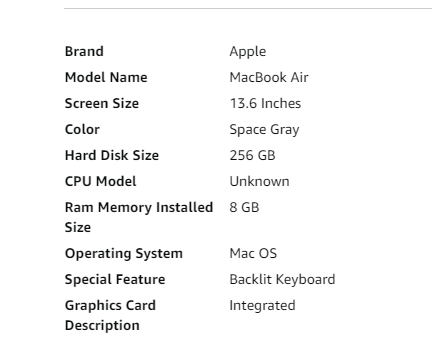
### <center>❗❗Here are some product specifications you can find in the above url❗❗

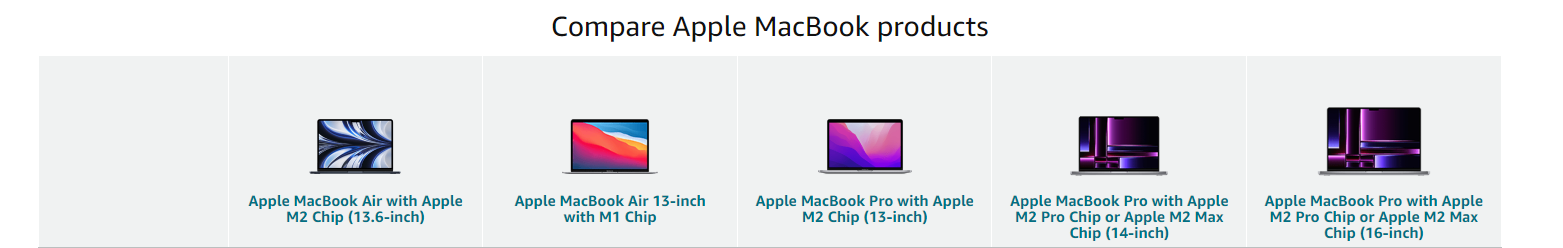

### <center>❗❗Here are some related links you can find in the above url❗❗

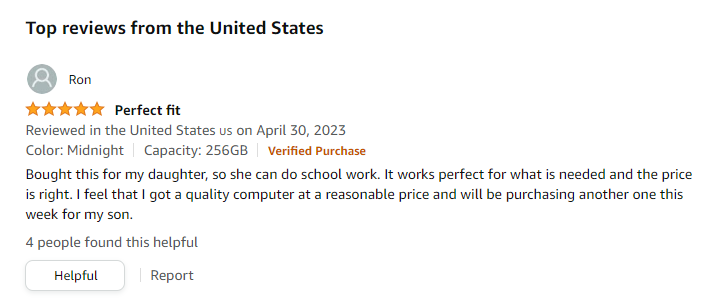

### <center>❗❗Here is a review you can find in the above url❗❗

Now that we have identified a suitable data source, let's get to scraping (I'm sure Amazon won't mind 😅). For this we will be using a mix of Selenium and bs4. Selenium will help avoid bot detection, bs4 will make processing the large amounts of html quicker.

An attempt was made to try using only requests and bs4, but Amazon's bot detection caught me and ip banned me for a couple hours, so this will have to do for now.

Note that the 'run_quick' paramater will determine if you scrape the data (ill-advised) or just load in the data immediately from what I scraped before (advised).

## Scrape Amazon Laptop Reviews + Metadata

In [3]:
if not run_quick:
    #set up a headless chrome browser
    #headless meaning no UI so just operates using commands
    #a browser will make it practically impossible for Amazon to detect us
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    driver = webdriver.Chrome(options=chrome_options)
    
    #initialize some links to crawl through
    links = [
            'https://www.amazon.com/2022-Apple-MacBook-Laptop-chip/dp/B0B3C2R8MP',
            'https://www.amazon.com/Apple-MacBook-Laptop-10%E2%80%91core-16%E2%80%91core/dp/B0BSHDVBXZ',
            'https://www.amazon.com/Lenovo-i7-1165G7-Processor-Graphics-82A6000BUS/dp/B08Z9T5HNM', 
            'https://www.amazon.com/SGIN-Windows-Celeron-Expandable-Storage/dp/B0BZS78JSQ',
            'https://www.amazon.com/HP-Computer-Processor-Graphics-SnowBell/dp/B08RPBG7G4',
            'https://www.amazon.com/Acer-SFX14-42G-R607-Creator-LPDDR4X-Backlit/dp/B09R8ZHZSD',
            'https://www.amazon.com/ASUS-Processor-NumberPad-Microsoft-L210MA-DB01/dp/B081V6W99V',
            'https://www.amazon.com/Samsung-Chromebook-Graphics-Celeron-Processor/dp/B08M2LB12T',
            'https://www.amazon.com/Apple-MacBook-13-inch-256GB-Storage/dp/B08N5M7S6K',
            'https://www.amazon.com/Alienware-M15-Gaming-Laptop-15-6-inch/dp/B09VQ3JWZ5',
            'https://www.amazon.com/MSI-i9-12900H-14-Core-GeForce-Thunderbolt/dp/B0BPN42FTQ',
            'https://www.amazon.com/Microsoft-Surface-Laptop-Touch-Screen-Matte-Black/dp/B08YX1WLVN'
            ]

    #limit how many links max you want to crawl through
    limit = 2_000

    #store scraped data in data list; one sample per laptop
    data = []

    #keep track of pages processed
    processed = set()

    #have progress bar to know program not stalling
    with tqdm(total=limit) as progress:
        #crawl through links
        for link in links:
            #update progress bar
            progress.update(1)

            #use selenium driver to get html rather than requests since selenium driver can bypass bot detection better
            driver.get(link)

            #obtain link's html content for tables only
            soup_tables = BeautifulSoup(driver.page_source, 'lxml', parseOnlyThese=SoupStrainer('table'))

            #find links in comparison table which suggests similar products
            for link in soup_tables.find_all("a"):
                #only want details page
                if '/dp/' in link['href']:
                    new_link = 'http://www.amazon.com' + link['href']
                    #prevent infinite crawling and repeat visits
                    #new_link not in links may cause an issue if we run out of unique links
                    #aka when the scraper doesn't go deep enough but so far no issue
                    if (len(links) < limit) and (new_link not in links):
                        links.append(new_link)
            
            #now try to get laptop specs
            try:
                name = driver.find_element(By.ID, "productTitle").text

                #might get the same sample from a different link so check if name is processed
                if name in processed:
                    continue

                processed.add(name)

                size = soup_tables.find("tr", class_="a-spacing-small po-display.size").\
                                find('td', class_='a-span9').text

                brand = soup_tables.find("tr", class_="a-spacing-small po-brand").\
                                 find('td', class_='a-span9').text

                memory = soup_tables.find("tr", class_=["a-spacing-small po-hard_disk.size", 
                                                          "a-spacing-small po-memory_storage_capacity"]).\
                                  find('td', class_='a-span9').text

                ram = soup_tables.find("tr", class_="a-spacing-small po-ram_memory.installed_size").\
                               find('td', class_='a-span9').text

                os = soup_tables.find("tr", class_="a-spacing-small po-operating_system").\
                              find('td', class_='a-span9').text

                cpu = soup_tables.find("tr", class_="a-spacing-small po-cpu_model.family").\
                              find('td', class_='a-span9').text

                gc = soup_tables.find("tr", class_="a-spacing-small po-graphics_description").\
                              find('td', class_='a-span9').text

                price = float((driver.find_element(By.CLASS_NAME, "a-price-whole").text +\
                               driver.find_element(By.CLASS_NAME, "a-price-fraction").text).replace(',',''))
            except:
                #if one of the feature values are missing (typically categorical), just skip the laptop
                #note though that this could lead to biases in the observations 
                
                #but the data will be imbalanced anyways (since amazon has more types of certain laptops than others)
                #so imputation using a features mode would also skew the data or even create false relationships
                
                #so ultimately i'd rather just leave out some observations, than ruin the integrity of the data
                continue

            #ignore laptops with no reviews otherwise can't run NLP models
            #this could also bias the observations but I can't impute reviews
            try:
                soup_reviews = BeautifulSoup(driver.find_element(By.ID, "cm-cr-dp-review-list").get_attribute('innerHTML'), 'lxml')
            except:
                continue

            #stores the reviews for this particular laptop   
            reviews = []

            #find all reviews + stars on front of product page
            for review in soup_reviews.find_all("div", {'data-hook':'review'}):
                try:
                    star = review.find("i", {'data-hook':'review-star-rating'}).text
                    comment = review.find("div", {'data-hook':'review-collapsed'}).text
                except:
                    #if no star/comment is available, do not add the review to the dataset
                    #since we cannot "impute" a review
                    
                    #i could impute a star,however, but I'm using the stars to train the models 
                    #so unless I use sentiment scores to impute the stars (invalid circular approach), 
                    #I could make the models perform worse
                    continue
                reviews.append((star, comment))



            sample = [name, size, brand, memory, ram, os, cpu, gc, price, reviews]
            data.append(sample)

    #combine the data into a dataframe
    df = pd.DataFrame(data, columns = ['name', 'size', 'brand', 'hhd', 'ram', 'os', 'cpu', 'graphics_card', 'price', 'reviews'])
else:
    #load data from file
    df = pd.read_csv('laptop4.csv', index_col=0, converters={'reviews': eval})

Phew! That was a lot... and very slow if you actually ran the scraper, but hopefully you had the 'run_quick' parameter set to True or you're just reading this without running the cells. Now that data collection is finished, let's move on to the most dreaded step of data science!!

# Step 3: Clean + Tidy The Data 😱

The first step of data processing is to understand how our data is represented. Currently, our data is represented as a table through a Pandas DataFrame object. This DataFrame stores samples in the rows and features in the columns, so the feature values corresponding to a sample y and feature x, is the intersection of row y and col x.

In [4]:
#make a copy of original dataset
df_tidy = df.copy()
#look at the format of the dataset
df_tidy.head()

,name,size,brand,hhd,ram,os,cpu,graphics_card,price,reviews
0,Apple 2022 MacBook Air Laptop with M2 chip: 13...,13.6 Inches,Apple,256 GB,8 GB,Mac OS,Unknown,Integrated,104900.0,"[(5.0 out of 5 stars, \nI am really happy with..."
1,Apple 2023 MacBook Pro Laptop M2 Pro chip with...,14.2 Inches,Apple,512 GB,16 GB,Mac OS,Unknown,Integrated,194864.0,"[(5.0 out of 5 stars, \nefore going into detai..."
2,"Lenovo IdeaPad Slim 7i 14.0"" Laptop, 14.0"" FHD...",14 Inches,Lenovo,512 GB,8 GB,Windows 10 Home,Intel Core i7,Integrated,66224.0,"[(3.0 out of 5 stars, \nI use it almost every ..."
3,"SGIN Laptop 15.6 Inch 4GB DDR4 128GB SSD, Wind...",15.6 Inches,SGIN,128 GB,4 GB,Windows 11 Home,Celeron N4020,Integrated,35999.0,"[(5.0 out of 5 stars, \nI bought this laptop s..."
4,"HP 2021 Stream 14"" HD SVA Laptop Computer, Int...",14 Inches,HP,64 GB,4 GB,Windows 10 S,Celeron N,Integrated,28900.0,"[(4.0 out of 5 stars, \nI bought this because ..."


### <center>❗❗The first 5 rows of our dataset❗❗

First let's clean our data. To do this, we know that we should use aggregate, group, and join operations since our data is represented as a table. Conveniently, Pandas has the functions: apply (for aggregation or mapping), groupby (for grouping features together), and join/merge (for combining tables). So let the cleaning begin, going from left to right, starting with 'name'!
<br><br>
Note that we could do data tidying first, but doing so would produce more rows so lets work with less data for as long as possible.

In [5]:
#Some of the names are too long since they include some of the technical specs of the laptop so lets split on ',' or ':'
df_tidy['name'] = df_tidy['name'].str.split(',|:').str[0]

In [6]:
#extract floating point number from size feature
#note size may have units at the end, they are stored in inches regardless
#(this may or may not be unique to US Amazon)
df_tidy['size'] = df_tidy['size'].str.extract(r'\s*(\d+\.?\d*)').astype('float')

In [7]:
#get the top10 laptop brands
#this will help prevent analyzing undersampled features
#also it will make analysis of results and models simpler
top10_brands = df_tidy.brand.str.strip().value_counts()[:10]

In [8]:
top10_brands

HP           352
ASUS         277
Lenovo       242
Acer         117
Dell          99
Microsoft     75
MSI           51
SAMSUNG       48
LG            23
Razer         16
Name: brand, dtype: int64

### <center>❗❗The top 10 laptop brands of our dataset❗❗

In [9]:
#label brands not in the top10 list as 'other'
df_tidy.brand = df_tidy.brand.apply(lambda brand: brand.strip() if brand.strip() in top10_brands.index else 'other')

In [10]:
#before we can work on cleaning the ram and hhd features we need to define the following functions
def translate_hhd_to_GB(s):
    x = int(re.search('\s*(\d+)', s).group(1))
    
    #units is gigabytes
    if 'gb' in s.lower():
        if x <= 8:
        #then gb was a mistag (no 8gb laptop)    
            return x * 1000
        else:
            return x
    #units is terabytes
    elif 'tb' in s.lower():
        if x > 8:
        #then tb was a mistage (no 8tb+ laptop)
            return x
        else:
            return x * 1000
            
    #no units must determine if tb or gb
    else:
        if x > 8:
            #is gb
            return x
        else:
            #is tb
            return x * 1000
        
def translate_ram_to_GB(s):
    x = int(re.search('\s*(\d+)', s).group(1))
    
    #units is gigabytes
    if 'gb' in s.lower():
        if x >= 1000:
        #then mistag (no 1tb ram laptop)
            return x / 1000
        else:
            return x
    #no units must determine if tb or gb
    elif 'mb' in s.lower():
        if x < 128:
        #then mistag (no 128 mb laptop)
            return x
        else:
            return x / 1000
    #no units must determine if gb or mb
    else:
        if x >= 1000:
            return x / 1000
        else:
            return x

In [11]:
#apply func to hhd
df_tidy.hhd = df_tidy.hhd.apply(translate_hhd_to_GB)

In [12]:
#Check for hhd outliers
df_tidy[(df_tidy.hhd > 6000) | (df_tidy.hhd < 16)]

,name,size,brand,hhd,ram,os,cpu,graphics_card,price,reviews
1244,HP Chromebook 14 Laptop,14.0,HP,0,4 GB,Chrome OS,Celeron N4000,Integrated,22499.0,"[(4.0 out of 5 stars, \nIt’s honestly just wha..."


### <center>❗❗This outlier is invalid so let's remove it by conditioning the feature❗❗

In [13]:
#remove the outlier, note we could visit the amazon page and fix the data manually but this would ruin the "pipeline" flow
df_tidy = df_tidy[(df_tidy.hhd <= 6000) & (df_tidy.hhd >= 16)]

In [14]:
#check for ram outliers
df_tidy.ram = df_tidy.ram.apply(translate_ram_to_GB)

In [15]:
df_tidy[(df_tidy.ram > 128) | (df_tidy.ram < 2)]

,name,size,brand,hhd,ram,os,cpu,graphics_card,price,reviews
141,SAMSUNG 15.6” Galaxy Book2 Pro with Intel ARC ...,15.6,SAMSUNG,1000,1,Windows,Core i7,Dedicated,189499.0,"[(5.0 out of 5 stars, \nGreat picture quality,..."
856,ASUS ZenBook S Ultra Slim Laptop,13.9,ASUS,1000,1,Windows 10 Pro,Intel Core i7,Intel Iris Xᵉ,169999.0,"[(4.0 out of 5 stars, \nI loved this laptop.Ov..."
1117,Microsoft Surface Pro 3 (256 GB,12.0,Microsoft,256,256,Windows 10 Pro,Core i5,Integrated,19995.0,"[(4.0 out of 5 stars, \nI'll start with this: ..."


### <center>❗❗These outliers are also invalid so let's remove it by conditioning the feature❗❗

In [16]:
#remoove the outliers
df_tidy = df_tidy[(df_tidy.ram <= 128) & (df_tidy.ram >= 2)]

In [17]:
#Fix column names
df_tidy.rename(columns={'size':'size_inches', 'hhd':'hhd_GB', 'ram':'ram_GB'}, inplace=True)

In [18]:
#Now extract the most popular os, cpu, and graphics card types and label the rest as "other"
#this process is similar to what we did for brand but involves much more regex
df_tidy.os.value_counts().head()

 Windows 11 Home     364
 Windows 10 Home     204
 Windows 11          202
 Chrome OS           183
 Windows 10          125
Name: os, dtype: int64

### <center>❗❗Some of the top OS of our dataset❗❗

In [19]:
#extract the os names
df_tidy.os = df_tidy.os.str.lower().str.extract(r'.*(?:(windows)\s*(\d+)\s*(?:home|pro|s)?)|.*(chrome)|.*(mac)')\
                .fillna('').agg(' '.join, axis=1).str.strip().replace('', 'other')

In [20]:
df_tidy.graphics_card.value_counts().head()

 Integrated      1058
 Dedicated        209
 RTX 3060          19
 RTX 3070 Ti       11
 RTX 3050 Ti       10
Name: graphics_card, dtype: int64

### <center>❗❗Some of the top graphics cards of our dataset❗❗

In [21]:
#extract the gpu names
df_tidy.graphics_card = df_tidy.graphics_card.str.lower().str.extract\
                            (r'.*(integrated)|.*(dedicated)|.*(rtx)|.*(gtx)|.*(mx)|.*(intel)')\
                            .fillna('').agg(' '.join, axis=1).str.strip().replace('', 'other')

In [22]:
df_tidy.cpu.value_counts().head()

 Core i7           126
 Celeron            94
 Core i5            94
 Intel Core i5      70
 Intel Core i7      66
Name: cpu, dtype: int64

### <center>❗❗Some of the top CPUs of our dataset❗❗

In [23]:
#extract the cpu names
df_tidy.cpu = df_tidy.cpu.str.lower().str.extract(r'.*(i\d)|.*(celeron)|.*(ryzen \d)|.*(amd)|.*(pentium)')\
                            .fillna('').agg(' '.join, axis=1).str.strip().replace('', 'other')

In [24]:
#fix the price so that the decimal point is 2 places left
#i couldve easily done this in the data scraping process but I forgot
df_tidy.price = df_tidy.price / 100

In [25]:
#check for outliers
df_tidy[(df_tidy.price > 50000) | (df_tidy.price < 20)]

,name,size_inches,brand,hhd_GB,ram_GB,os,cpu,graphics_card,price,reviews
17,SGIN 15.6 Inch aptop 4GB DDR4 128GB SSD,15.6,other,128,4,windows 11,celeron,integrated,2.7495,"[(5.0 out of 5 stars, \nI bought this laptop s..."


In [26]:
#remove outliers
df_tidy = df_tidy[(df_tidy.price <= 50000) & (df_tidy.price >= 20)]

Now before we can clean the 'reviews' feature we need to note that our data is stored very conveniently; it is almost tidy by design (I made sure when scraping to format it somewhat tidily).<br>
<br>
Here are the rules we have to follow to ensure tidyness:
- Each column should hold a single variable 
- Each row should hold a single observation
- Each cell should hold a single value (if you follow the first two rules, then each cell should have a single value)<br>
</ul>
More info at https://arimoroolayinka.medium.com/a-gentle-introduction-to-tidy-data-in-r-b6673b4d304c
<br>
<br>
The main issue is that the 'reviews' variable is actually 2 variables with multiple observations: a list of (star, text) tuples. So we need to expand it so that each row only has one value for star rating and one value for text.

In [27]:
#split the reviews list into multiple rows with a unique (star, text) tuple (for each tuple in the list)
#explode makes this very convenient; its kind of like melting a dataset but for values instead of features\
#this will create a lot more rows/observations since now each observation is not just a laptop but a review for that laptop
df_tidy_exploded = df_tidy.explode('reviews').reset_index()

In [28]:
#Now create a new function that will extract the star rating and text from each 'reviews' tuple
#and add the rating and text as new features to replace the previous 'reviews' tuple
def split(r):
    rating, review = r
    rating = int(re.search(r'(\d)', rating).group(1))
    review = review.replace("\n", "")
    return pd.Series([rating, review], index=['rating', 'review'])

In [29]:
#apply the func
df_tidy_exploded = df_tidy_exploded.join(df_tidy_exploded.reviews.apply(split), how='left').drop( ['index', 'reviews'], axis=1)

In [30]:
#Now create a function that determines if a review is in English
#we want to remove non-english reviews so that our NLP models work better
def isEnglish(r):
    try:
        #check if first 50 words are english
        return detect(r[:50]) == 'en'
    except:
        return False

In [31]:
#apply the func
if not run_quick:
    df_tidy_exploded = df_tidy_exploded[df_tidy_exploded.review.progress_apply(isEnglish)].reset_index().drop(['index'], axis=1)
else:
    df_tidy_exploded = pd.read_csv('english_reviews_only', sep='\t', index_col=0)

In [32]:
#look at the sample of the final result
df_tidy_exploded.sample(5)

,name,size_inches,brand,hhd_GB,ram_GB,os,cpu,graphics_card,price,rating,review
7552,"HP 2022 Newest Pavilion 15.6"" FHD 1080P IPS La...",15.6,HP,1000,32,windows 11,ryzen 7,other,843.22,5,This is a great PC for the money. Extremely fa...
5622,Acer Chromebook Spin 311 CP311-2H-C3KA Convert...,11.6,Acer,64,4,chrome,celeron,integrated,153.93,3,Product arrived without any physical blemishes...
6749,ASUS VivoBook 15 Thin and Light Laptop,15.6,ASUS,1000,4,windows 10,celeron,integrated,275.00,5,Exactly what I expected.Very nice laptop. Had...
5056,Dell Inspiron 13 5000 5310 Premium Laptop I 13...,13.3,Dell,512,16,windows 11,i5,integrated,607.22,1,The computer was working just fine for about 4...
5576,"Lenovo Legion 5 15.6""",15.6,Lenovo,512,8,windows 11,ryzen 5,integrated,749.00,5,thank you so much! Very fast delivery and good...


### <center>❗❗A sample of the cleaned and tidied dataset❗❗

YAAY!! 🥳🥳 We're done with the most tedious part of the data science pipeline. Now let's get on to the more fun parts of data science: data visualization!!

Note that we didn't have to deal with missing data because we dealed with it in the web scraping step (just dropped observations with missing values instead of finding relationships and imputing because I care more about the accuracy of the data and don't want to produce false relationships, further explanation in the comments of the data collection step). 

# Step 4: Exploratory Data Analysis + Visualization 🔥

In this step we want to get a "feel" for the data through summary statistics and visualizations. We want to identify variable relationships and distributions so that we know what ML models we can and can't use with our data. Also, by gaining this background knowledge of our data, we can better explain things when they go wrong.

In [33]:
df_tidy_exploded.corr(numeric_only=True)

,size_inches,hhd_GB,ram_GB,price,rating
size_inches,1.000000,0.491069,0.416445,0.421194,-0.009320
hhd_GB,0.491069,1.000000,0.727549,0.693177,-0.029787
ram_GB,0.416445,0.727549,1.000000,0.681493,-0.024704
price,0.421194,0.693177,0.681493,1.000000,-0.027780
rating,-0.009320,-0.029787,-0.024704,-0.027780,1.000000


### <center>❗❗A correlation matrix between the numeric features of the exploded data set❗❗

Above is a correlation matrix between the numeric variables of our exploded dataset. Observe the correlations with rating only since the other correlation coefficients are not valid (remember in the exploded dataset, one sample is a review not a laptop).

Looking at this correlation matrix, you can see that all the numeric variables have a weak negative correlation with rating. This somewhat goes against expectations because wouldn't users be happier more hhd and more ram? The somewhat negative correlation between price and rating, and size and rating could make sense if you reason that people want cheaper and more portable laptops.

However, this observation should be taken cautiously since the correlation coefficients are so close to 0, this we may just be trying to create patterns out of chaos.

In [34]:
df_tidy.corr(numeric_only=True)

,size_inches,hhd_GB,ram_GB,price
size_inches,1.000000,0.473186,0.413983,0.409433
hhd_GB,0.473186,1.000000,0.738469,0.696047
ram_GB,0.413983,0.738469,1.000000,0.691577
price,0.409433,0.696047,0.691577,1.000000


### <center>❗❗A correlation matrix between the numeric features of the original data set❗❗

Now let's try to see if we can explain those negative correlations by looking at this correlation matrix; the correlation matrix of the (pre-exploded) dataset where each observation is a laptop.

As you can see there are some fairly positive and strong correlations between hhd, ram, and price. So this can be interpreted as: as price increases so does hhd and ram through a moderate to strong linear relationship. This makes sense because you pay a higher price for more memory. 

Also note that screen size has a weak-moderate positive correlation with the other 3 variables. This also makes sense because bigger laptops (like gaming ones) tend to come with more memory and a heftier price tag.

Lets plot these relationships.

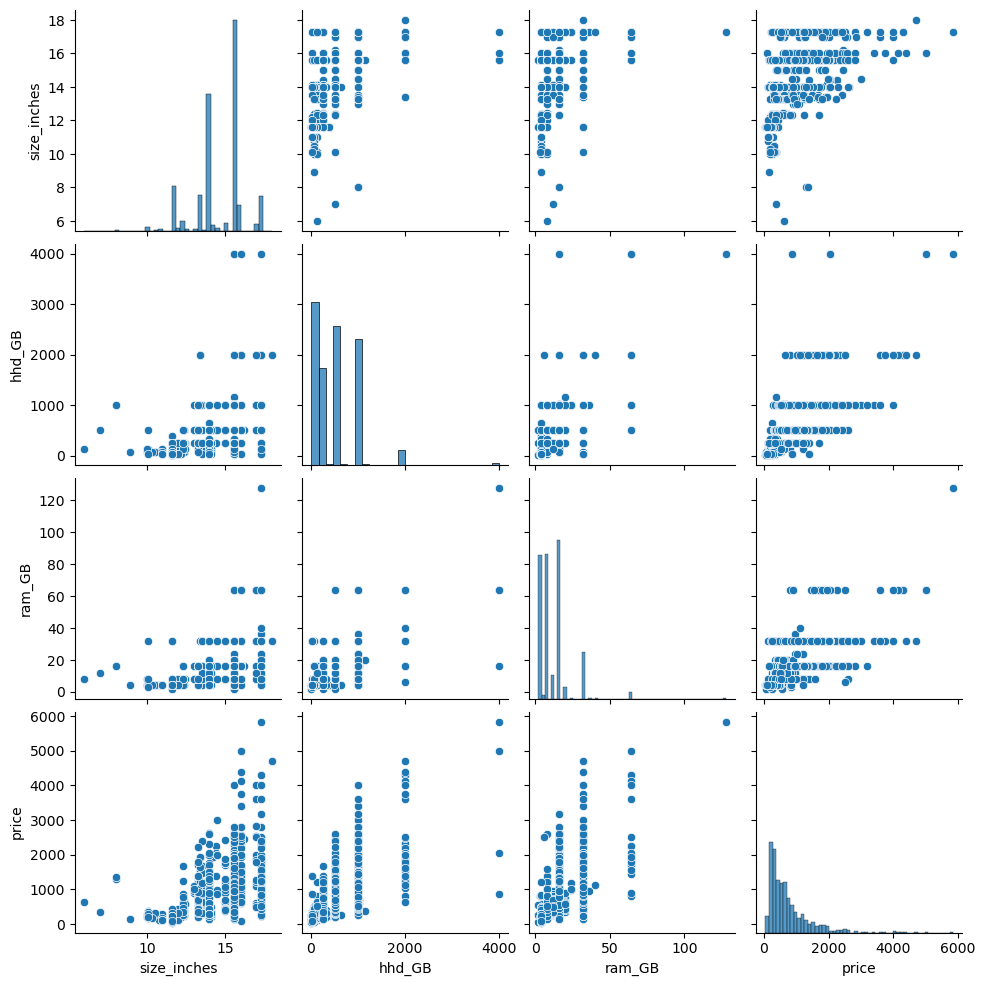

In [35]:
sns.pairplot(data=df_tidy)

### <center>❗❗Plots of the relationships between numeric features and their distributions❗❗

As you can see there are slight positive linear relationships between these variables.

So perhaps we can conclude that the slight negative relationships we saw with rating stems from the fact that the other numeric features scale positively with price, and obviously price would scale negatively with rating (because no one wants to pay more). However, this is just a hypothesis, and should be kept in the back of our head until we prove it in the ML section of this project (especially since the negative relationships are suspiciously low, perhaps they're not statistically significant).

Anyways, let's see how the nominal(string) variables scale with price and rating to get a better idea of this price-rating relationship. One way to do this would be to perform one-hot encoding for our categorical data i.e. transform values into vectors of 0's and 1 indicating the presence of a certain feature value, and then using the correlation matrix again. 

However, this sounds boring and is definitely more complex than what I have in mind. Instead, lets just plot the nominal data vs average price. Before we can do this, let's take a closer look at the price distribution.

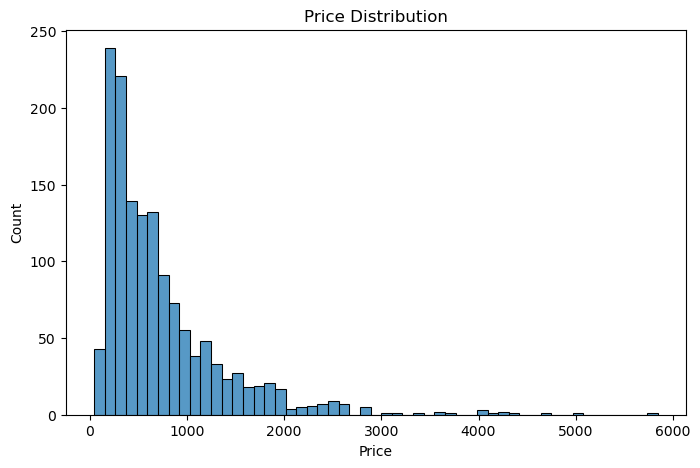

Mean: 732.835624123422
Median: 544.5
STD: 646.4337442875417


In [36]:
plt.figure(figsize=(8,5))
ax = sns.histplot(data=df_tidy, x='price')
plt.title("Price Distribution")
plt.ylabel("Count")
plt.xlabel("Price")
plt.show()
print(f'Mean: {df_tidy.price.mean()}', f'Median: {df_tidy.price.median()}', f'STD: {df_tidy.price.std()}', sep='\n')

Here we can see that the price distribution is skewed heavily to the right. So for our measure of 'average' when plotting relationships with the price, let's use median instead of mean. Furthermore, the standard deviation is 646 so on average the laptop prices are around +/-\\$646 from the mean of \\$732 so our data has a lot of variety and potential imbalances so we need to keep that in mind for when we start doing ML.

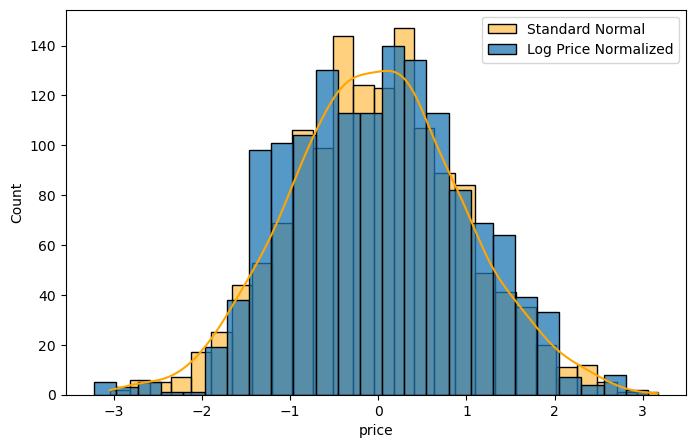

In [37]:
fig, axs = plt.subplots(1,1, figsize=(8,5))
np.random.seed(0)
log_price = np.log(df_tidy.price) 
#sample as many elements as are in log price from the normal distribution
standard_normal = np.random.standard_normal(size=log_price.size)

#plot the density of the standard normal with sample size = price's size
sns.histplot(x=standard_normal, kde=True, color='orange', label='Standard Normal')
#standardize the normal
sns.histplot(x=(log_price - log_price.mean()) / log_price.std(), ax=axs, label='Log Price Normalized')
axs.legend()
plt.show()

An interesting thing occurs when you log the prices and then normalize them: you get a distribution similar to that of the standard normal, so this means that the farther we get from the average price, the more exponential price grows (i.e. higher end laptops are exponentially more expensive than the average laptop). We can keep this in mind in case some of our models we decide to use work better with standard normal data.

Okay, now that we have an idea of price's distribution let's investigate rating's distribution.

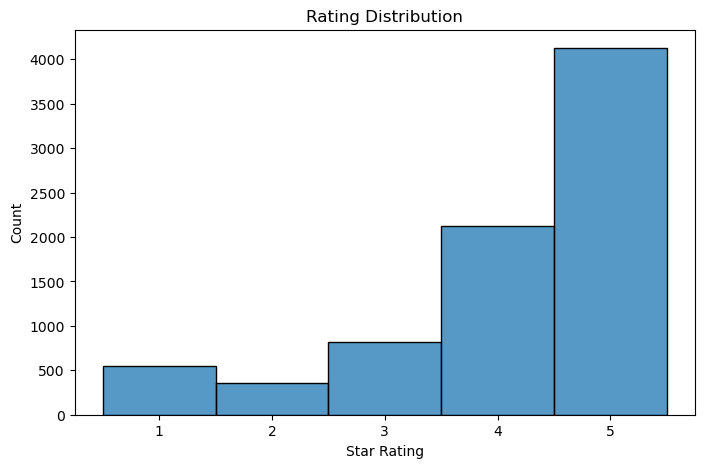

In [38]:
plt.figure(figsize=(8,5))
ax = sns.histplot(data=df_tidy_exploded, x='rating', discrete=True)
plt.title("Rating Distribution")
plt.ylabel("Count")
plt.xlabel("Star Rating")
plt.show()

Clearly, if we used median for star rating vs (some_feature) we will lose a lot of the nuances, since it will most like be 5 or 4 for every feature since this is a discrete variable. So let's use mean.

Okay, now that we're done investigating the price and rating, let's investigate the relationship of the nominal features to price (using median) and to rating (using mean). Also, for fun (since the pairplot is kind of hard to read) I'll also plot the numerical/ordinal features as well.

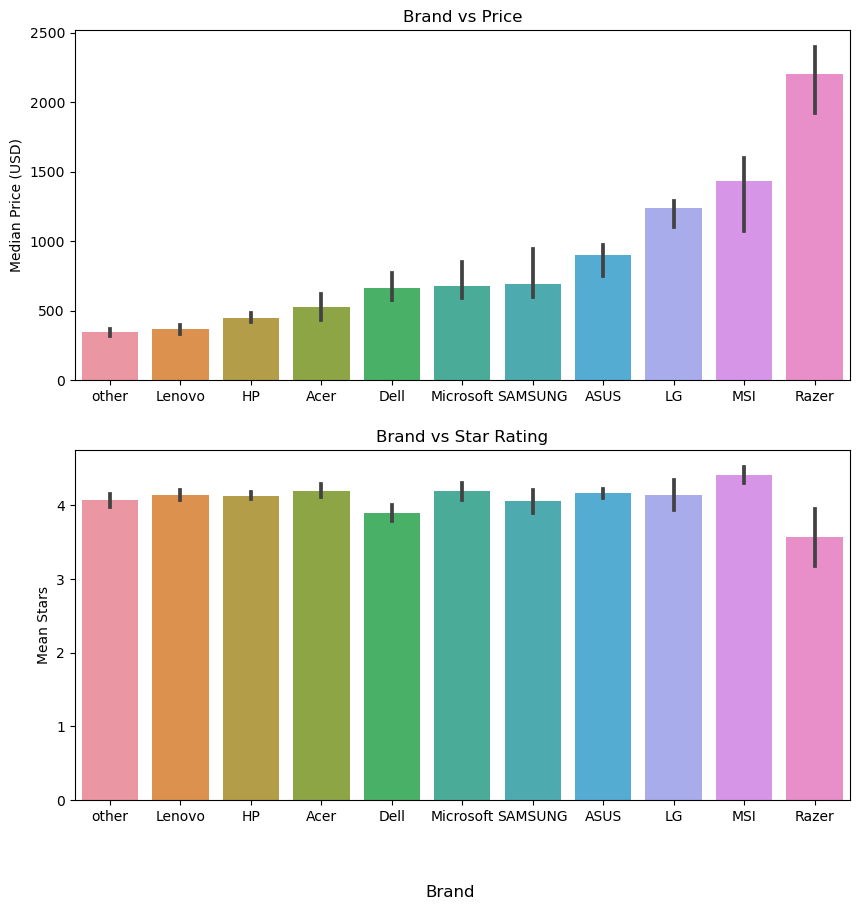

In [39]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
#use median as measure of y value
sns.barplot(data=df_tidy, x='brand', y='price', estimator=np.median, \
                 order=df_tidy.groupby('brand').price.median().sort_values().index.values, ax=axs[0])
#use mean as measure of y value
sns.barplot(data=df_tidy_exploded, x='brand', y='rating', estimator=np.mean, \
                 order=df_tidy.groupby('brand').price.median().sort_values().index.values, ax=axs[1])

axs[0].set_title('Brand vs Price')
axs[0].set(xlabel=None, ylabel='Median Price (USD)')
axs[1].set_title('Brand vs Star Rating')
axs[1].set(xlabel=None, ylabel='Mean Stars')
fig.supxlabel("Brand")

plt.show()

### <center>❗❗Looks like price is related to brand, but brand is not related to star rating, <center><gb>though it is interesting to see that the most expensive is the lowest rated❗❗

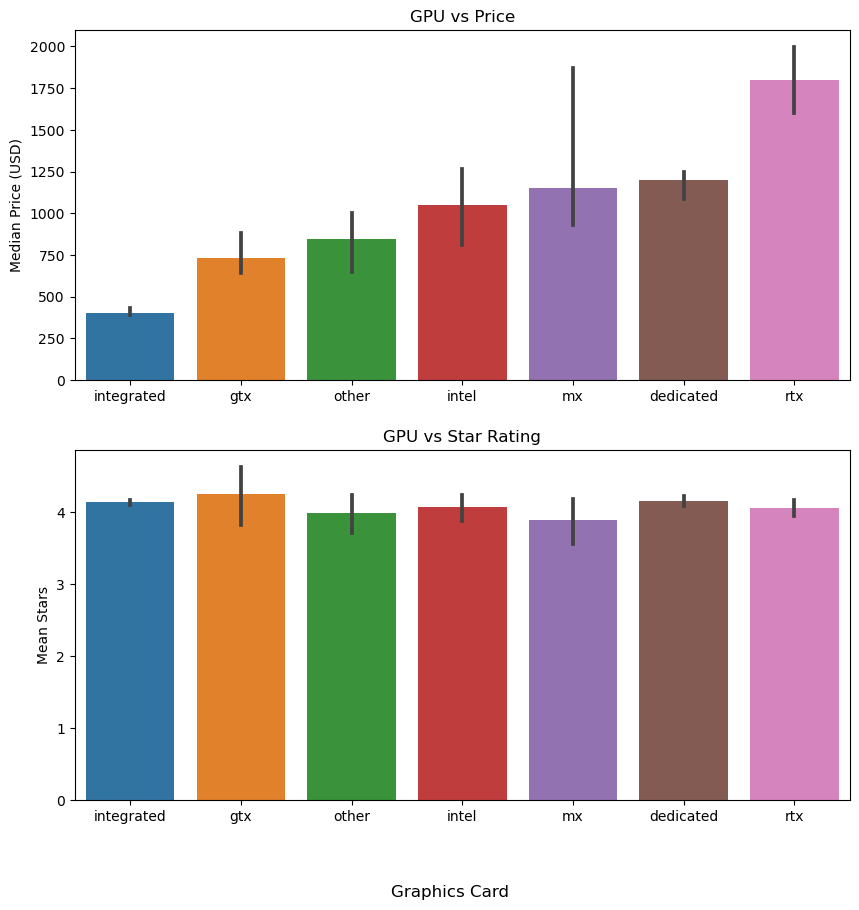

In [40]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
sns.barplot(data=df_tidy, x='graphics_card', y='price', estimator=np.median, \
                 order=df_tidy.groupby('graphics_card').price.median().sort_values().index.values, ax=axs[0])

sns.barplot(data=df_tidy_exploded, x='graphics_card', y='rating', estimator=np.mean, \
                 order=df_tidy.groupby('graphics_card').price.median().sort_values().index.values, ax=axs[1])

axs[0].set_title('GPU vs Price')
axs[0].set(xlabel=None, ylabel='Median Price (USD)')
axs[1].set_title('GPU vs Star Rating')
axs[1].set(xlabel=None, ylabel='Mean Stars')
fig.supxlabel("Graphics Card")

plt.show()

### <center>❗❗Looks like price is related to GPU, but GPU is not related to star rating❗❗

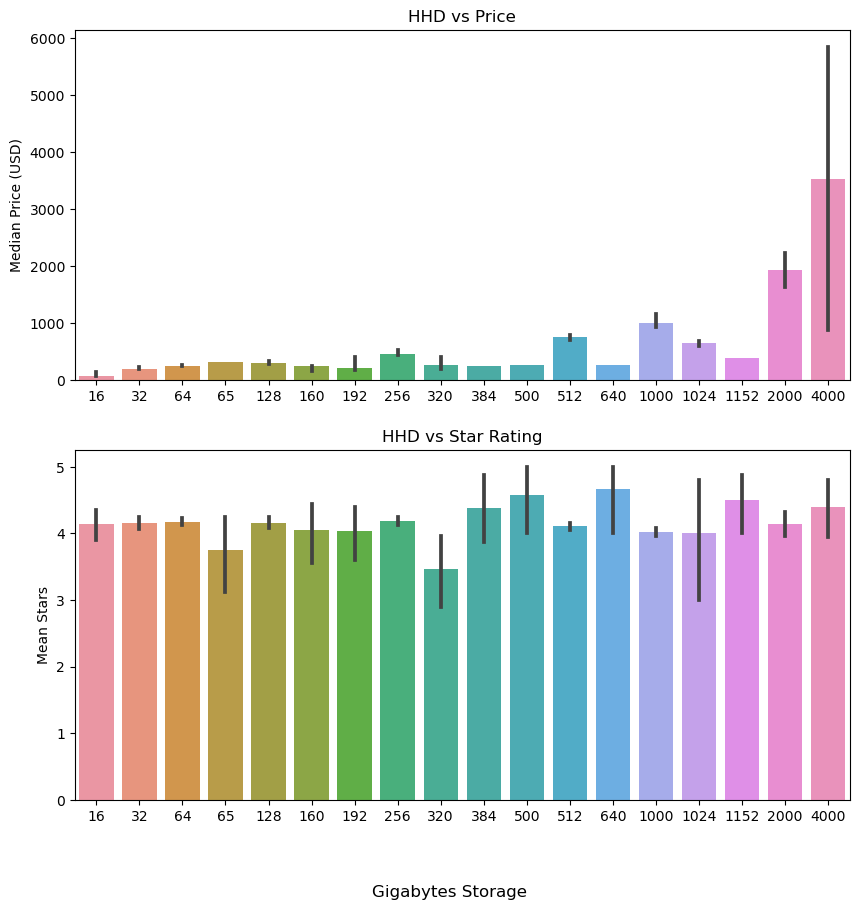

In [41]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
sns.barplot(data=df_tidy, x='hhd_GB', y='price', estimator=np.median, ax=axs[0])

sns.barplot(data=df_tidy_exploded, x='hhd_GB', y='rating', estimator=np.mean, ax=axs[1])

axs[0].set_title('HHD vs Price')
axs[0].set(xlabel=None, ylabel='Median Price (USD)')
axs[1].set_title('HHD vs Star Rating')
axs[1].set(xlabel=None, ylabel='Mean Stars')
fig.supxlabel("Gigabytes Storage")

plt.show()

### <center>❗❗Looks like price is positively related to HHD, but HHD is not really related to star rating❗❗

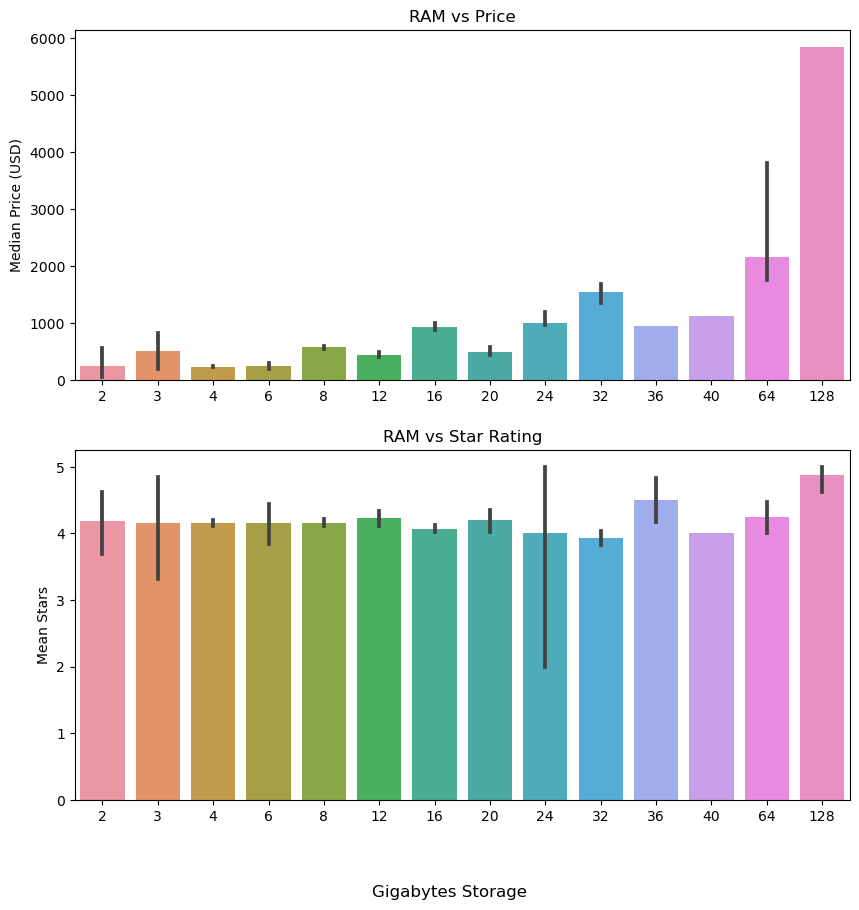

In [42]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
sns.barplot(data=df_tidy, x='ram_GB', y='price', estimator=np.median, ax=axs[0])

sns.barplot(data=df_tidy_exploded, x='ram_GB', y='rating', estimator=np.mean, ax=axs[1])

axs[0].set_title('RAM vs Price')
axs[0].set(xlabel=None, ylabel='Median Price (USD)')
axs[1].set_title('RAM vs Star Rating')
axs[1].set(xlabel=None, ylabel='Mean Stars')
fig.supxlabel("Gigabytes Storage")

plt.show()

### <center>❗❗Looks like price is positively related to RAM, but RAM is not really related to star rating❗❗

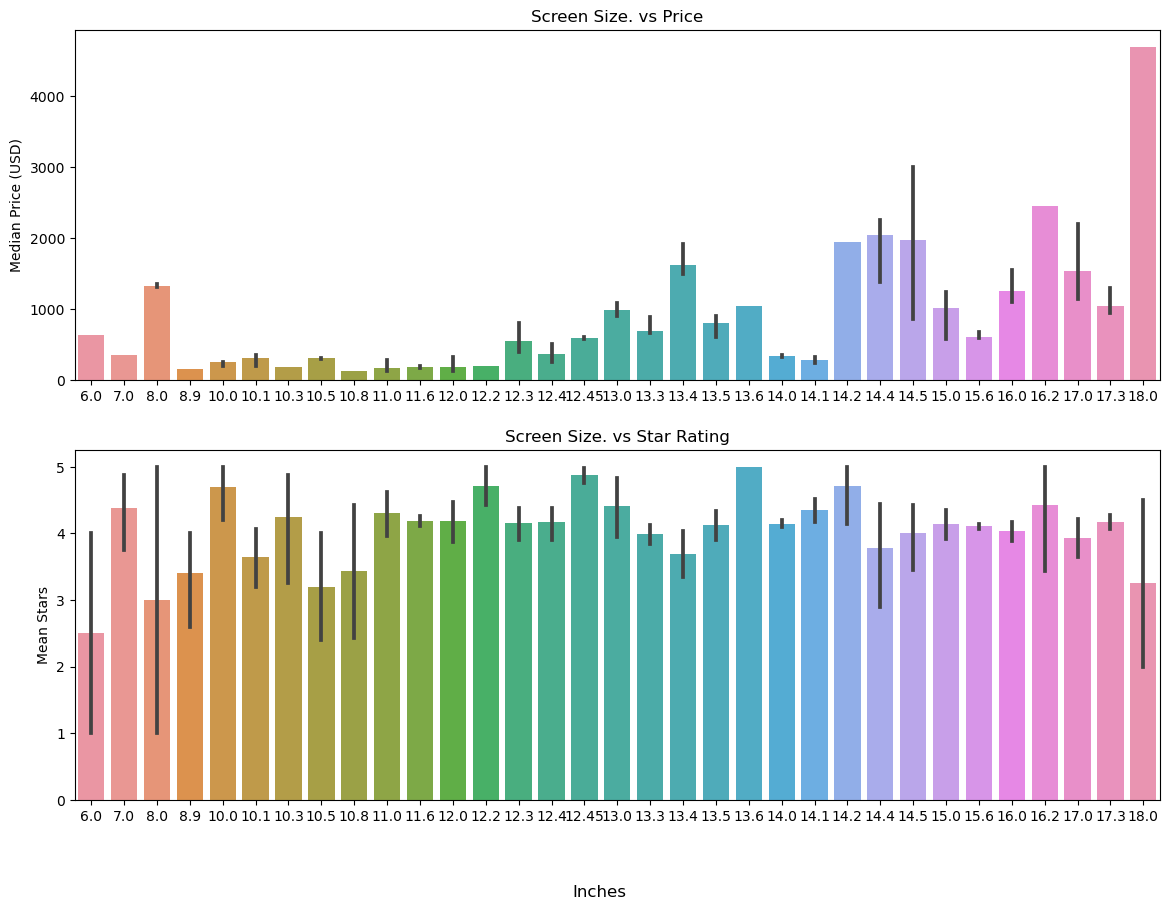

In [43]:
fig, axs = plt.subplots(2,1, figsize=(14,10))
sns.barplot(data=df_tidy, x='size_inches', y='price', estimator=np.median, ax=axs[0])

sns.barplot(data=df_tidy_exploded, x='size_inches', y='rating', estimator=np.mean, ax=axs[1])

axs[0].set_title('Screen Size. vs Price')
axs[0].set(xlabel=None, ylabel='Median Price (USD)')
axs[1].set_title('Screen Size. vs Star Rating')
axs[1].set(xlabel=None, ylabel='Mean Stars')
fig.supxlabel("Inches")

plt.show()

### <center>❗❗Looks like price is positively related with screen size,<gb><center>also you could say that stars is related to size at the extreme ends,<gb><center>i.e. too small => decrease in rating, too large => decrease in rating,<gb><center>perhaps this indicates a quadratic relationship❗❗

So as we can see these features impact price, but don't seem to really impact rating (except for screen size which we will keep in mind for later). So I'm lead to believe that rating is independent of price?

Now lets plot the direct comparison between price and rating to see, though we will need to do a hypothesis test to truly confirm this.

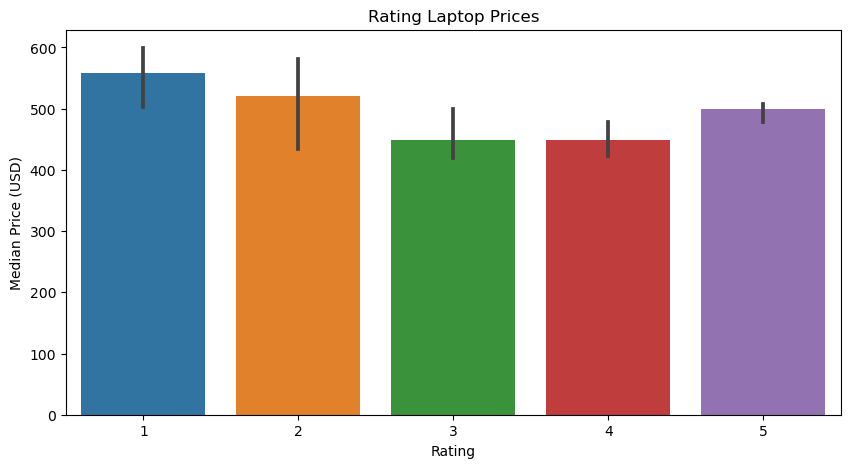

In [44]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_tidy_exploded, x='rating', y='price', estimator=np.median)
plt.title("Rating Laptop Prices")
plt.ylabel("Median Price (USD)")
plt.xlabel("Rating")
plt.show()

### <center>❗❗Looks like price is not really related to rating, at least linearly visually, maybe quadratically?❗❗

So from what we've seen so far, features impact price, but price doesn't really impact ratings (or at least not in an obivous way we can inuitively visualize). 

Also, screen size is one feature that seems to impact ratings in an intuitive way. So we've explored the relationships between our variables so now lets start verifying some of these relationships and building models based on them.

# Step 5: ML + Hypothesis Testing 🤖💡

In this section we will use Hypothesis testing first to confirm or deny our beliefs from the data exploration/visualization step. Then we will use ML to try to predict ratings, and NLP to find another metric of sentiment: sentiment scores.

## Hypothesis testing

First let's test if price and rating have a linear or quadratic relationship. 

The null hypothesis of any regression problem would be that the model doesn't exist, i.e. the coefficients are 0. 
Now, we have to set a level of significance, or alpha-value. This will be the lowest probability we will tolerate of an observed outcome assuming our null hypothesis. 

So for these tests we will use a level of significance of 0.05, meaning that we will tolerate extreme outcomes that have at least a 5% chance of being observed; so we can expect to reject a true null hypothesis 5% of the time just by chance.

So for instance, if the observed outcome (or more extreme) occurs with a probability of 0.04 assuming our null hypothesis, we will reject the null hypothesis because that probability is too low (below a = 0.05).

In [45]:
#set the level of significance to the standard a = 0.05
level_of_sig = 0.05

In [46]:
#create a linear model y = x0 + c1x1
linear_price_rating = statsmodels.formula.api.ols(formula = 'rating ~ price', data = df_tidy_exploded).fit()
print(f'Price\'s p-value: {linear_price_rating.pvalues.price}')
print(f'Statistically significant: {linear_price_rating.pvalues.price < level_of_sig}')

Price's p-value: 0.013167722395347222
Statistically significant: True


### <center>❗❗Linear regression model of Price vs Rating p-values❗❗

In [47]:
#create a quadratic model y = x0 + c1(x1**2)
quadratic_price_rating = statsmodels.formula.api.ols(formula = 'rating ~ I(price**2)', data = df_tidy_exploded).fit()
print(f'Price**2\'s p-value: {quadratic_price_rating.pvalues[1]}')
print(f'Statistically significant: {quadratic_price_rating.pvalues[1] < level_of_sig}')

Price**2's p-value: 0.043883883413297284
Statistically significant: True


### <center>❗❗Quadratic regression model of Price vs Rating p-values❗❗

It seems that the linear model is a better fit than the quadratic model because we can be more confident that it's parameter is significant since it has a lower p-value. So now let's look at that coefficient. 

In [48]:
linear_price_rating.params.price * 1_000

-0.05315055698661708

### <center>❗❗For every \\$1,000 increase in price, rating goes down by 0.05 on average❗❗

So it turns out that there is some sort of subtle linear relationship we couldn't see before, but the hypothesis test concludes is statistically significant.

Let's see if we can improve the model by making the price normal by taking the log, as we saw before.

In [49]:
z = np.log(df_tidy_exploded.price)
z = (z -z.mean())/z.std()
df_tidy_exploded['zprice'] = z

In [50]:
#create a linear model y = x0 + c1x1
linear_zprice_rating = statsmodels.formula.api.ols(formula = 'rating ~ zprice', data = df_tidy_exploded).fit()
print(f'Normalized Price\'s p-value: {linear_zprice_rating.pvalues.zprice}')
print(f'Statistically significant: {linear_zprice_rating.pvalues.zprice < level_of_sig}')

Normalized Price's p-value: 0.057311370714363284
Statistically significant: False


### <center>❗❗Linear regression model of Normalized Price vs Rating p-values❗❗

So that didn't work... perhaps because the rating variable is not normalized, but the price is? Regardless if I were to redo the model with both variables normalized, then the interpretation of the model would get a bit confusing. So let's just stick with our previous linear relationship (without the normalization).

Now remember from the data visualizations part, we could kind of see a pattern between size and rating where if size was too small or too large, rating would go down in a sort of quadratic fashion. Let's test to see if the screen size has a linear or quadratic relationship with rating.

In [51]:
linear_size_rating = statsmodels.formula.api.ols(formula = 'rating ~ size_inches', data = df_tidy_exploded).fit()
print(f'Size\'s p-value: {linear_size_rating.pvalues.size_inches}')
print(f'Statistically significant: {linear_size_rating.pvalues.size_inches < level_of_sig}')

Size's p-value: 0.40560842955894705
Statistically significant: False


### <center>❗❗Linear regression model of Screen size vs Rating p-values❗❗

In [52]:
quadratic_size_rating = statsmodels.formula.api.ols(formula = 'rating ~ I(size_inches**2)', data = df_tidy_exploded).fit()
print(f'Size**2\'s p-value: {quadratic_size_rating.pvalues[1]}')
print(f'Statistically significant: {quadratic_size_rating.pvalues[1] < level_of_sig}')

Size**2's p-value: 0.3445732192303693
Statistically significant: False


### <center>❗❗Quadratic regression model of Screen size vs Rating p-values❗❗

Maybe we have to center the data to see the quadratic relationship (so the model can detect low/high extremes as the same event of being far from 0).

In [53]:
df_tidy_exploded['centered_size'] = df_tidy_exploded.size_inches - df_tidy_exploded.size_inches.mean()

In [54]:
quadratic_csize_rating = statsmodels.formula.api.ols(formula = 'rating ~ I(centered_size**2)', data = df_tidy_exploded).fit()
print(f'Centered Size**2\'s p-value: {quadratic_csize_rating.pvalues[1]}')
print(f'Statistically significant: {quadratic_csize_rating.pvalues[1] < level_of_sig}')

Centered Size**2's p-value: 0.34946472241303794
Statistically significant: False


### <center>❗❗Quadratic regression model of Centered Screen size vs Rating p-values❗❗

So it turns out there really isnt any significant relationship between price and screen size.

So in summary, we saw that there might be relationships between rating and price, and rating and screen size; it turns out that there is only a statistically significant relationship between rating and price, verified by hypothesis tests. However, I might've missed something since my models were quite simple, so let's keep this in mind when trying to find a good ML model that can predict rating.

For now, let's finally start our sentiment analysis. Hopefully we will be able to use the sentiment scores as a better predictor for rating (so we know our sentiment scores are somewhat valid), and if that holds we can combine the rating and sentiment scores to have a more reliable metric of customer satisfaction which will guide our policy decisions. 

Also, if we can predict the rating well, then we have a method of labeling un-rated text on a star scale (assigning a star to text without stars), which is valuable because the star scale is the most familiar and easy to interpret metric.

## Vader Pretrained Bag of Words Model

Vader is a bag of words NLP model, which means that it doesn't care about grammer, it only cares about the frequencies of words. Basically, the model has a vocabulary and each word has some sentiment score/weight assigned to it. Then after counting the frequences of the recognized words in the text, it can calculate the total sentiment scores of the text.

This model in particular gives a neg, neu, pos, and compound score. The compound score ranges from -1 to 1 and is generally used to classify if the overall text is positie, negative, or neutral.

Also, note that Vader handles text preprocessing so we can just use it right away.

In [55]:
#create vader model
vader = SentimentIntensityAnalyzer()

In [56]:
#calculate sentiment scores
scores = df_tidy_exploded.review.apply(lambda s: vader.polarity_scores(s).values())

In [57]:
df_tidy_vader = df_tidy_exploded.join(pd.DataFrame(scores.to_list(), columns=['neg', 'neu', 'pos', 'compound']))

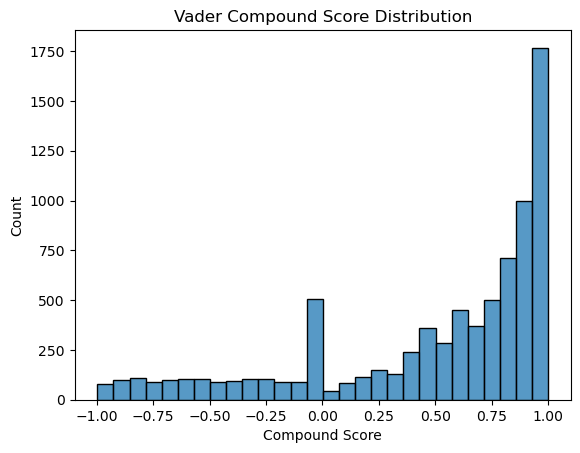

In [58]:
sns.histplot(data=df_tidy_vader, x='compound')
plt.title("Vader Compound Score Distribution")
plt.ylabel("Count")
plt.xlabel("Compound Score")
plt.show()

### <center>❗❗Distribution of Vader compound scores❗❗

Now, this compound score doesn't really mean much until we assign it an actual sentiment. We will use the standard scoring thresholds according to github documentation of neg = \[-1, -.5\], pos = \[.5, 1\], and neu = (-.5, .5).

In [59]:
#set thresholds for classification step
neg_threshold = -0.5
pos_threshold = 0.5

In [60]:
#classify according to vader compound score
df_tidy_vader['vader_class'] = df_tidy_vader.compound.apply(lambda x: 'pos' if x >= pos_threshold else 'neg' if x <= neg_threshold else 'neu')

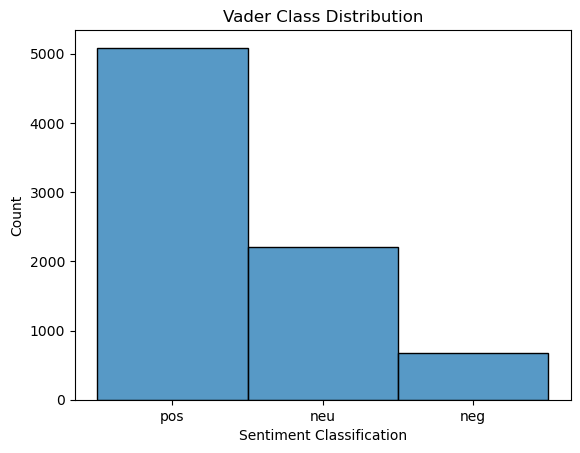

In [61]:
sns.histplot(data=df_tidy_vader, x='vader_class')
plt.title("Vader Class Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment Classification")
plt.show()

### <center>❗❗Distribution of Vader Sentiment classifications❗❗

In [62]:
df_tidy_vader.rating.value_counts()

5    4125
4    2128
3     814
1     543
2     354
Name: rating, dtype: int64

### <center>❗❗Reminder of the distribution of stars❗❗

This distribution seems about right since we saw before that the stars are skewed towards high ratings. However, I would've expected more negatives than neutrals since the there are more 1 and 2 stars than 3 stars.

Let's see if Vader got the classifications correct through a different visualization.

An easy way to see this is look at the word cloud for positive texts, and then the world cloud for negative texts.

In [63]:
#create a word cloud that allows bi-grams (words found in pairs) and removes stopwords automatically
wc = WordCloud(collocation_threshold = 1, collocations = True)

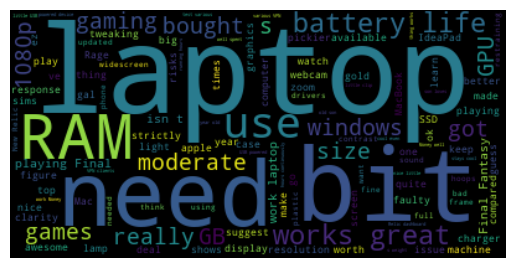

In [64]:
#take a sample so it doesn't take too long to generate the clouds
positive_reviews = df_tidy_vader[df_tidy_vader.vader_class == 'pos'].review.sample(10)
wc.generate(positive_reviews.str.cat(sep=' '))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### <center>❗❗Word cloud of positive reviews determined by Vader❗❗

As you can see we should try to remove some nouns because they don't really give much sentiment without context and word clouds are contextless. We should also attempt to clean some of the text while we're at it (like fix mispellings, expand contractions, force lower case. Hopefully these two things will result in a clearer word cloud. So let's do that now.

Note that this wont remove 100% of the nouns since Parts of Speech tagging isn't 100% correct all the time, so we will just remove nouns as best as we can.

In [65]:
#define functions to clean text and remove nouns from text
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
speller = SpellChecker()
def clean(s):
    #lowercase
    s = s.lower()
    
    #fix mispellings
    spelled = [speller.correction(w) for w in word_tokenize(s) if speller.correction(w) != None]
    
    #expand contractions
    expanded = contractions.fix(" ".join(spelled))
    
    #remove links
    s = re.sub(r'http\S+','', s)
    #remove numbers
    s = re.sub(r'\d+', '', s)

    #remove nouns, punctuation, and lemmatize
    tokens = []
    for tok, pos in pos_tag(tokenizer.tokenize(expanded)):
        if pos[0] != "N":
            tokens.append(lemmatizer.lemmatize(tok, get_wordnet_pos(pos)))
            
    
    #remake the sentence
    sentence = " ".join(tokens)
    return sentence

#return part of speech in correct format
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

  0%|          | 0/10 [00:00<?, ?it/s]

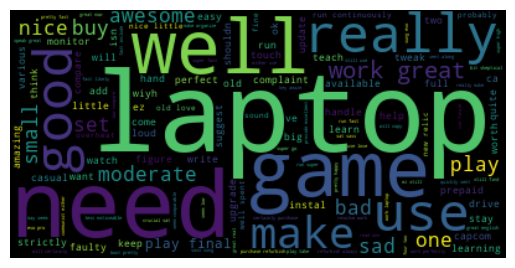

In [66]:
#clean the positive reviews
cleaned = positive_reviews.progress_apply(clean)
wc.generate(cleaned.str.cat(sep=' '))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### <center>❗❗Word cloud of cleaned positive reviews determined by Vader❗❗

  0%|          | 0/10 [00:00<?, ?it/s]

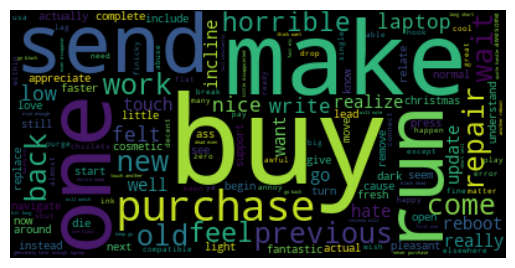

In [67]:
negative_reviews = df_tidy_vader[df_tidy_vader.vader_class == 'neg'].review.sample(10)
cleaned_neg = negative_reviews.progress_apply(clean)
wc.generate(cleaned_neg.str.cat(sep=' '))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### <center>❗❗Word cloud of cleaned negative reviews determined by Vader❗❗

Now remember one of our goals is to be able to assign unlabeled data a star rating, and one of our approaches was to try to use the laptop's specs which didn't work very well (except for price, but even then the correlation was very weak). Now that we have sentiment scores, let's see if there's some sort of relationship between rating and the compound score.

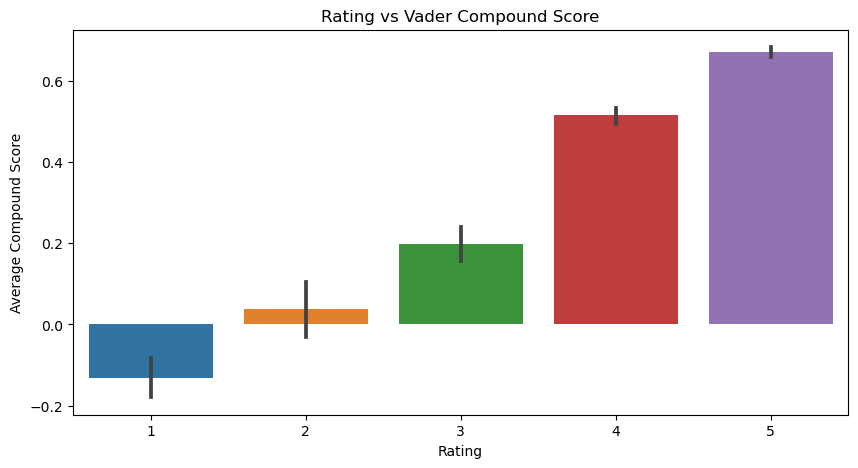

In [68]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_tidy_vader, x='rating', y='compound')
plt.title("Rating vs Vader Compound Score")
plt.ylabel("Average Compound Score")
plt.xlabel("Rating")
plt.show()

### <center>❗❗Seems like there's a linear positive relationship between rating and compound score❗❗

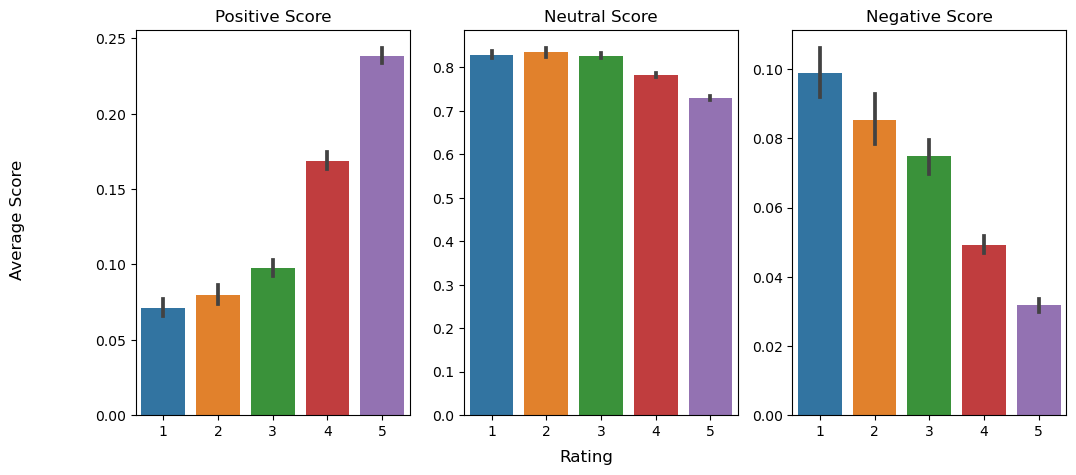

In [69]:
fig, axs = plt.subplots(1,3, figsize=(12,5))
sns.barplot(data=df_tidy_vader, x='rating', y='pos', ax=axs[0])
sns.barplot(data=df_tidy_vader, x='rating', y='neu', ax=axs[1])
sns.barplot(data=df_tidy_vader, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive Score')
axs[0].set(xlabel=None, ylabel=None)
axs[1].set_title('Neutral Score')
axs[1].set(xlabel=None, ylabel=None)
axs[2].set_title('Negative Score')
axs[2].set(xlabel=None, ylabel=None)
fig.supxlabel("Rating")
fig.supylabel("Average Score")
plt.show()

### <center>❗❗The positive and negative scores also display a linear relationship; neutral not so much❗❗

This is great news!! We created a feature from the reviews (sentiment scores) that look closely related to ratings. So perhaps we can use these scores to predict ratings. But before we do that, let's try another NLP model.

## Roberta Pretrained transformer model

Transformers are a type of neural network optimized for analyzing language. They are particularly good at analyzing language because they employ 3 important techniques called positional encoding, attention and self-attention. One of the most popular transformer models is called BERT. We will be using a modification of BERT called RoBERTa that has been trained on tweets.
The model we're using can only process a maximum of 512 tokens, and some of our reviews will produce more than 512 tokens so there are two solutions.
- 1. Truncate the tokens, which will result in some information loss
- 2. Use a longformer (which can handle more than 512 tokens) and train it yourself
</ul>
I will be using solution 1 because it is a common technique used and solution 2 would take too much time to do.

To learn more about transformers you can watch this video...<br>
https://www.youtube.com/watch?v=SZorAJ4I-sA

In [70]:
#initialize the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.model_max_length = 512
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
#define the function that will run the model
def ROBERTA(r):
    #some sequences may have more than 512 tokens; just truncate here rather than seperate into chunks
    #chunking requires aggregation of token representations
    #also no pretrained longformers exist for sentiment analysis
    tokens = tokenizer(r, return_tensors='pt', truncation=True, padding='max_length') 
    output = model(**tokens) #unpack the tokens dict
    scores = output[0][0].detach().numpy() #turn tensor into np
    scores = softmax(scores) #normalize between 0 and 1
    return scores

In [72]:
#apply the model
if not run_quick:
    roberta_scores = pd.DataFrame(df_tidy_exploded.review.progress_apply(ROBERTA).to_list())
else:
    roberta_scores = pd.read_csv('roberta_scores2', sep='\t', index_col=0)
roberta_scores.columns = ['neg', 'neu', 'pos']

In [73]:
#merge the scores with the other meta-data
df_tidy_roberta = df_tidy_exploded.join(roberta_scores)

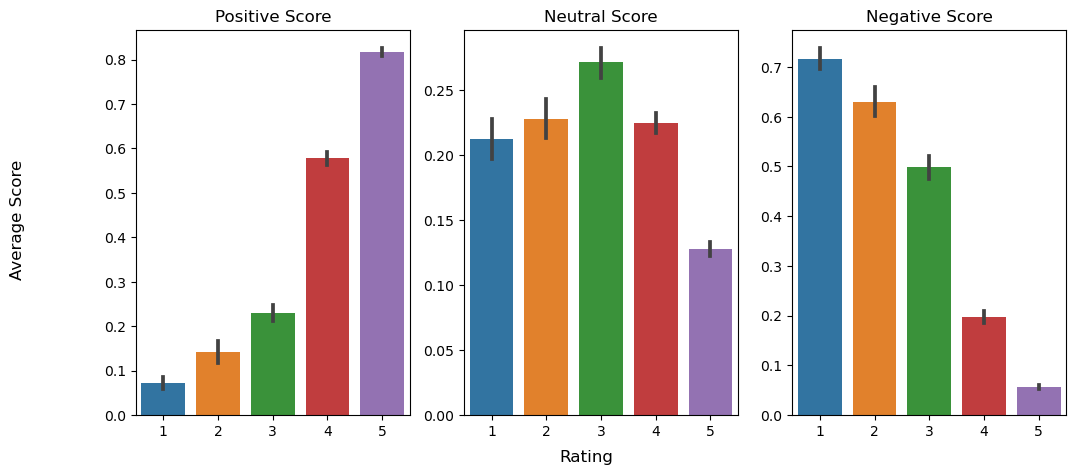

In [74]:
#look at the Roberta scores
fig, axs = plt.subplots(1,3, figsize=(12,5))
sns.barplot(data=df_tidy_roberta, x='rating', y='pos', ax=axs[0])
sns.barplot(data=df_tidy_roberta, x='rating', y='neu', ax=axs[1])
sns.barplot(data=df_tidy_roberta, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive Score')
axs[0].set(xlabel=None, ylabel=None)
axs[1].set_title('Neutral Score')
axs[1].set(xlabel=None, ylabel=None)
axs[2].set_title('Negative Score')
axs[2].set(xlabel=None, ylabel=None)
fig.supxlabel("Rating")
fig.supylabel("Average Score")
plt.show()

### <center>❗❗The positive and negative scores also display a linear relationship; and the neutral a quadratic one❗❗

This is even greater news! It looks like Roberta is giving us even more information than Vader because we can now see that there is a quadratic relationship between the neutral score and rating. This makes sense because as the ratings become more polarized there should be less neutral sentiment.

However, note that there is no compound score, so when comparing these models we can only use the pos, neg, and neu scores. We cannot generate a compound score for Roberta because a compound score is generated throughout the analysis; it cannot be formulated from the neg, neu, and pos scores.

Also, now lets look at the classifications instead of scores. We will assign the sentiment beased off the majority scores, as is done in the documentation for this model.

In [75]:
#classify according to roberta scores
df_tidy_roberta['roberta_class'] = df_tidy_roberta[['neg','neu','pos']] \
    .apply(lambda x: 'pos' if x.pos == max(x.neg, x.neu, x.pos) else 'neg' if x.neg == max(x.neg, x.neu, x.pos) else 'neu', axis=1)

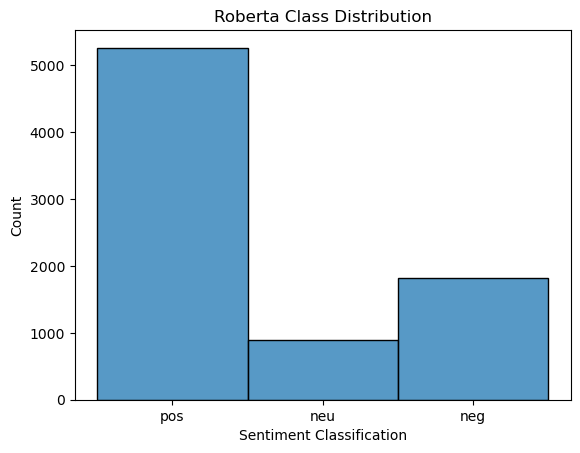

In [76]:
sns.histplot(data=df_tidy_roberta, x='roberta_class')
plt.title("Roberta Class Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment Classification")
plt.show()

### <center>❗❗Distribution of Roberta Sentiment classifications❗❗

Once again, this looks very promising, so let's compare the models to see which we should stick with.

## Comparing the models

In [77]:
#merge both model's scores
df_scores = df_tidy_vader[['neg','neu','pos', 'vader_class']].join(df_tidy_roberta[['neg','neu','pos', 'roberta_class']], lsuffix='_vader', rsuffix='_roberta')

Let's look at the correlation matrix between their scores to see if the gave similar results at all.

In [78]:
df_scores.corr(numeric_only=True)

,neg_vader,neu_vader,pos_vader,neg_roberta,neu_roberta,pos_roberta
neg_vader,1.000000,-0.107338,-0.337092,0.429730,0.065580,-0.373763
neu_vader,-0.107338,1.000000,-0.899846,0.261103,0.406359,-0.402013
pos_vader,-0.337092,-0.899846,1.000000,-0.435785,-0.413565,0.544661
neg_roberta,0.429730,0.261103,-0.435785,1.000000,0.180291,-0.882975
neu_roberta,0.065580,0.406359,-0.413565,0.180291,1.000000,-0.620921
pos_roberta,-0.373763,-0.402013,0.544661,-0.882975,-0.620921,1.000000


Shockingly, the model's scores are only weak-moderately correlated, with correlation coefficients .429, .406, and .544 for neg, neu, and pos respectively. Let's look at the pairplot to get a better look at these relationships.

In [79]:
#merge the scores with the meta-data
complete_df = df_tidy_exploded.join(df_scores)

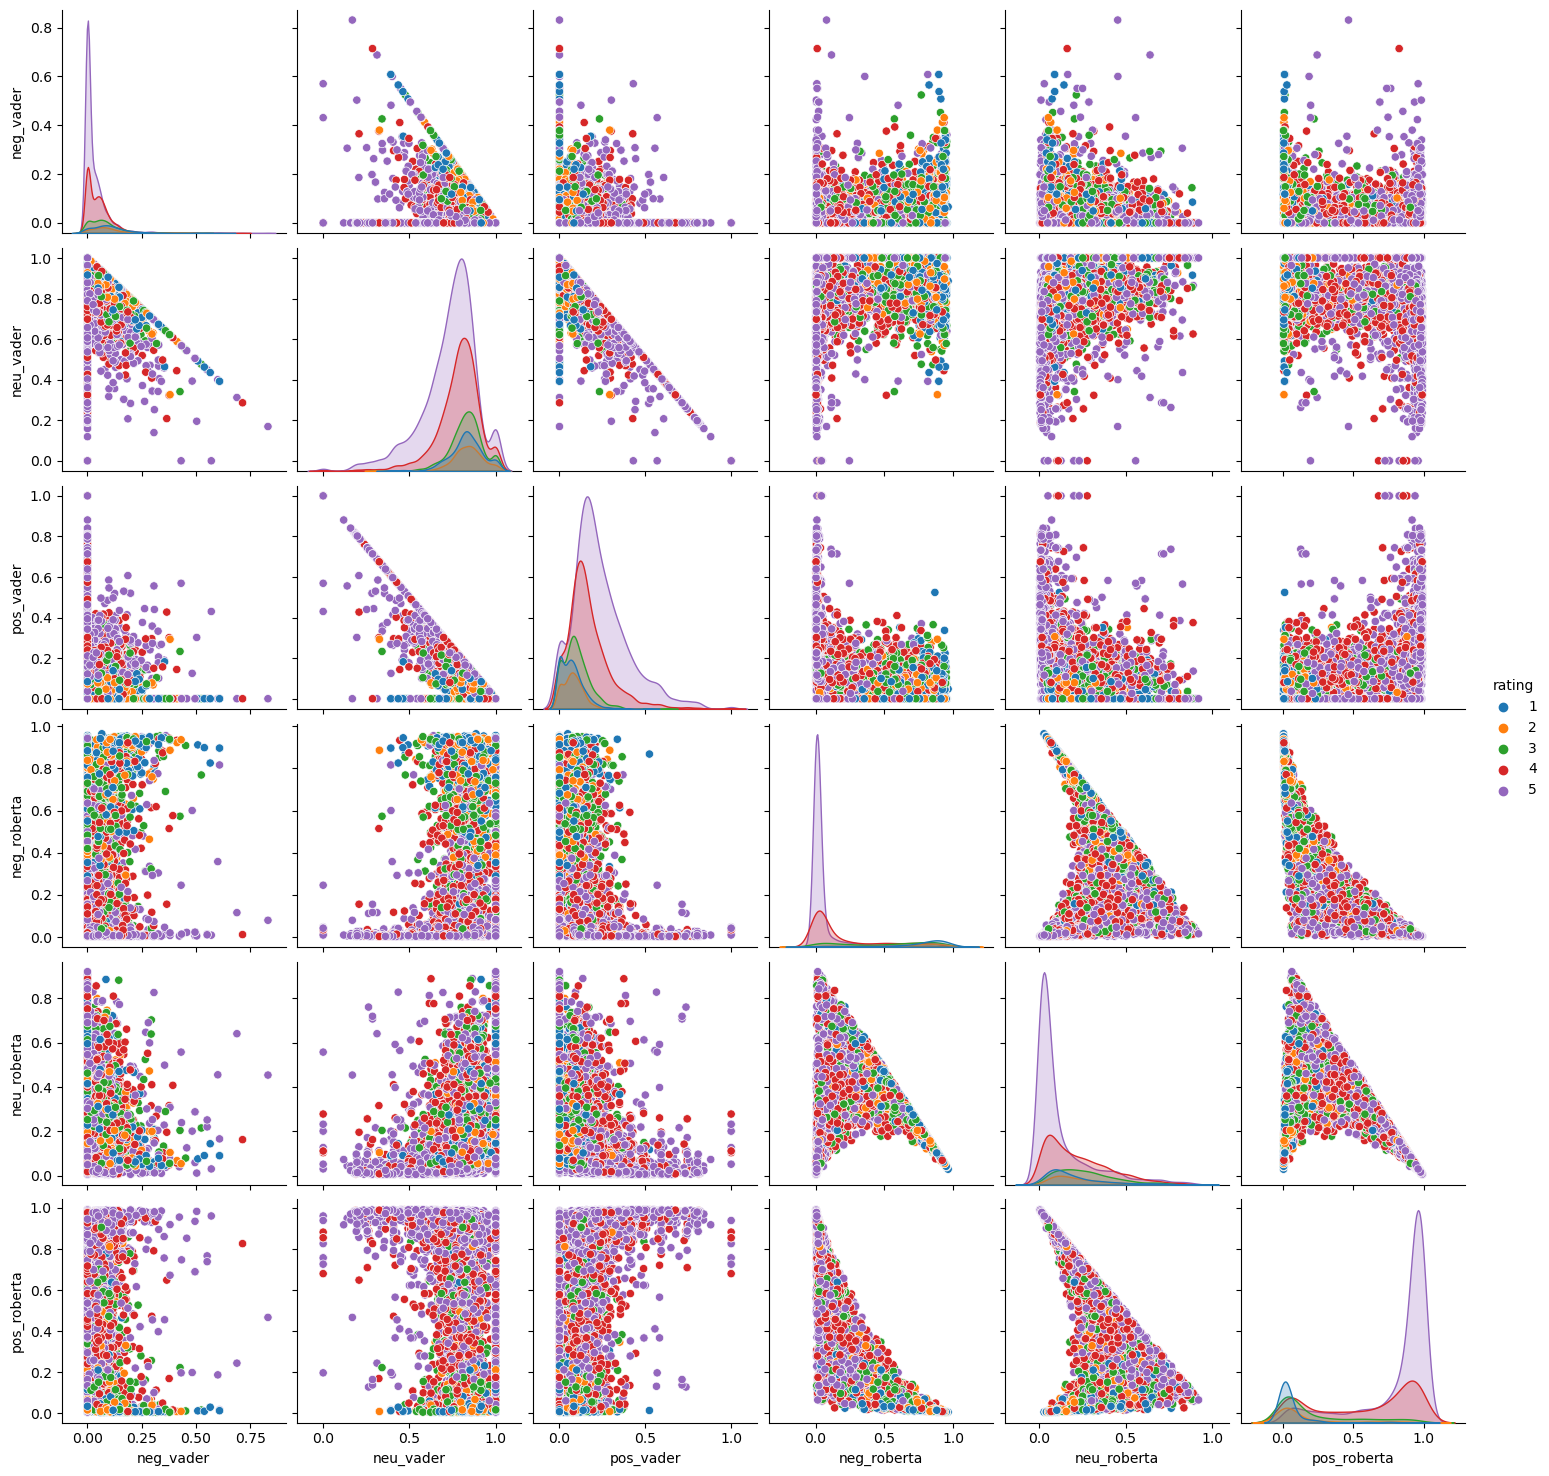

In [80]:
sns.pairplot(data=complete_df, palette='tab10', hue='rating', vars=['neg_vader', 'neu_vader', 'pos_vader',\
                                                                   'neg_roberta', 'neu_roberta', 'pos_roberta'])
plt.show()

### <center>❗❗Comparing models' score distributions and correlations❗❗

As you can through the main diagonal, the Vader model is less sensitive to extreme positive and negative sentiments, but highly sensitive to neutral sentiments since the bulk of the neutral distribution is on the right (high neutral scores) whereas the bulk of the positive and negative distributions are on the left (low positive/negative scores). This makes sense when you think about it because Vader is a bag of words model; it has no context to know if a text is polarizing, it only knows the frequency of words so it would give a sentence like "this laptop ruined my lovely day" a neutral score since "ruined" and "lovely" balance each other out, when in reality it's very negative. Note, also that each rating has a similar central tendency, so 5 stars have a similar neg_score as 1 stars; this can be concerning.

On the other hand, the Roberta model is highly sensitive to extreme positive sentiments, and less sensitive to neutral and negative sentiments. However, it is more sensitive to negative sentiments than neutral sentiments as you can see that theres a second mode on the right side of the negative distribution (for ratings 1, 2, and 3), whereas the neutral distribution is unimodal, with mode near zero. Note that the distributions change based on rating. For instance, 1 star ratings mostly have 0 positive scores, where as 5 star ratings mostly have 1 positive scores; this is good because it follows our intuition.

You could argue that the Roberta model is more sensitive to the extremes especially by looking at the different distributions of ratings in the positive and negative scores. This makes sense because the model was trained on tweets, which are typically either extremely positive or negative, and because it uses context unlike Vader.

The Vader model seems to be more neutral and the central tendencies of negative, neutral, and positive scores across different ratings seems to be similar implying that perhaps the model is seeing the same common words over and over, and thus the scores are only tipped slightly by the ocassional polarizing word it sees, which makes sense for a bag of words approach.

Also, as noted by the correlation matrix above there is a very weak pos relation between the matching sentiments of both models. The relationships almost look random, but have a slight direction up and to the right.

## Comparing Predicted Values to Actual Values

Okay, now that we understand the differences between the Vader and Roberta model, lets compare them to the actual observed values. However, there is an issue. The observed results we have in our dataset is represented as stars, whereas the predicted values are represented as sentiment classifications ('pos', 'neg', or 'neu').

There are two approaches we can take...
- 1. Convert the stars into a sentiment classification
- 2. Convert the sentiment classification into a star rating
</ul>

In both situations we have to map one domain to another, which can be tricky. But notice that solution 2. is similar to one of our goals stated in the introduction of this notebook: predict star rating. We don't want to do this yet wihtout knowing which model to use, so let's do solution 1.

Note that there is no clear cut way to convert stars to sentiments. Generally, one could assume that 4,5 stars = positive, 3 stars = neutral, and 1,2 stars = negative. However, star ratings might be skewed for a reason. For instance, maybe Amazon customers are too nice so they're more inclined to give 4 or 5 stars even when their sentiment isn't super positive. Also, some could view a 3 star as slightly positive, or maybe slightly negative, or even perfectly neutral. The issue I'm trying to get at is that not everyone uses the star scale the same way. This is one of the reasons we're analyzing sentiment (because sentiment score classifications are more objective based on a threshold, or majority).

So, ultimately, we have to apply multiple mappings to the star ratings to see which one is the most accurate. This may sound confusing, but once you see the graph it will all click.

In [81]:
#do an unbiased mapping
complete_df['actual_class_unbiased'] = complete_df.rating \
    .apply(lambda x: 'pos' if x in [4,5] else 'neg' if x in [1,2] else 'neu')

In [82]:
#do a very positively biased mapping
complete_df['actual_class_very_biased_pos'] = complete_df.rating \
    .apply(lambda x: 'pos' if x in [5,4,3] else 'neg' if x in [1] else 'neu')
complete_df.actual_class_very_biased_pos = pd.Categorical(complete_df.actual_class_very_biased_pos, ['pos','neu','neg'])

In [83]:
#do a verry negatively biased mapping
complete_df['actual_class_very_biased_neg'] = complete_df.rating \
    .apply(lambda x: 'pos' if x in [5] else 'neg' if x in [3,2,1] else 'neu')
complete_df.actual_class_very_biased_neg = pd.Categorical(complete_df.actual_class_very_biased_neg, ['pos','neu','neg'])

In [84]:
#do a slightly positive mapping
complete_df['actual_class_slightly_biased_pos'] = complete_df.rating \
    .apply(lambda x: 'pos' if x in [5,4] else 'neg' if x in [1] else 'neu')
complete_df.actual_class_slightly_biased_pos = pd.Categorical(complete_df.actual_class_slightly_biased_pos, ['pos','neu','neg'])

In [85]:
#do a slightly negative mapping
complete_df['actual_class_slightly_biased_neg'] = complete_df.rating \
    .apply(lambda x: 'pos' if x in [5] else 'neg' if x in [2,1] else 'neu')
complete_df.actual_class_slightly_biased_neg = pd.Categorical(complete_df.actual_class_slightly_biased_neg, ['pos','neu','neg'])

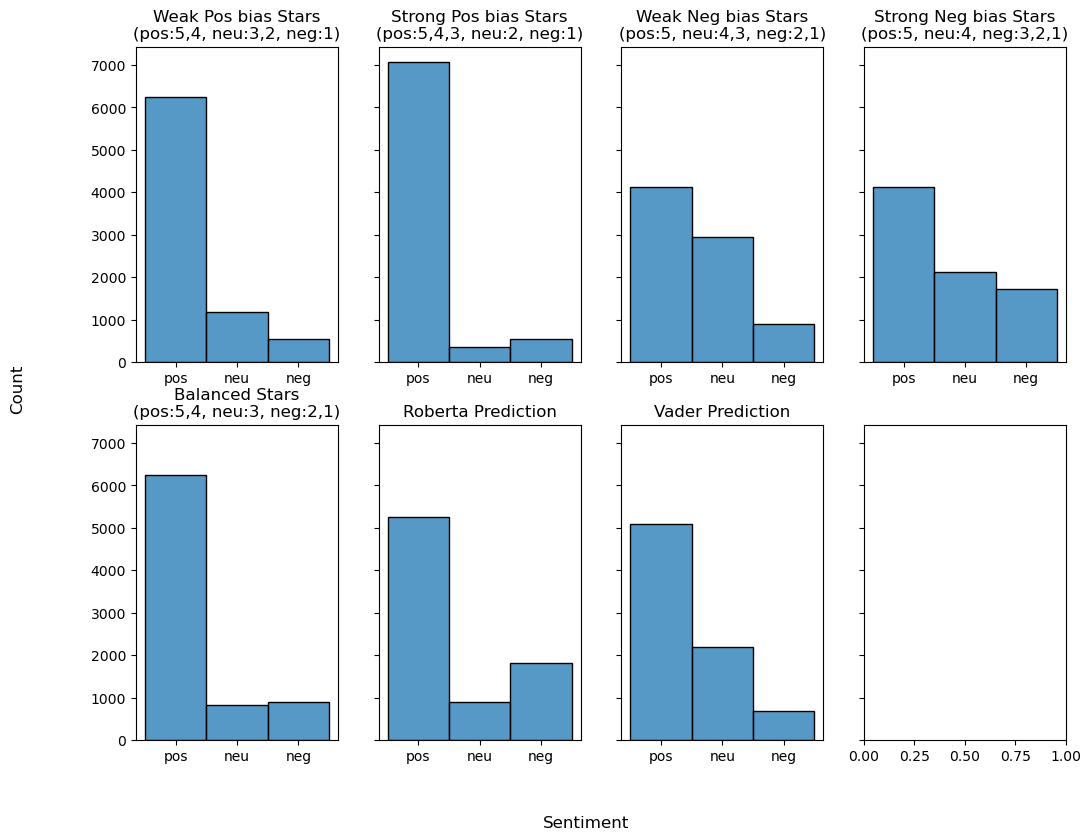

In [86]:
#plot the result distributions of the mappings along with the vader and roberta classification distributions
fig, axs = plt.subplots(2,4, figsize=(12,9), sharey=True)
sns.histplot(data=complete_df, x='actual_class_slightly_biased_pos', ax=axs[0][0])
sns.histplot(data=complete_df, x='actual_class_very_biased_pos', ax=axs[0][1])
sns.histplot(data=complete_df, x='actual_class_slightly_biased_neg', ax=axs[0][2])
sns.histplot(data=complete_df, x='actual_class_very_biased_neg', ax=axs[0][3])


sns.histplot(data=complete_df, x='actual_class_unbiased', ax=axs[1][0])
sns.histplot(data=complete_df, x='roberta_class', ax=axs[1][1])
sns.histplot(data=complete_df, x='vader_class', ax=axs[1][2])

axs[0][0].set_title('Weak Pos bias Stars\n(pos:5,4, neu:3,2, neg:1)')
axs[0][0].set(xlabel=None, ylabel=None)

axs[0][1].set_title('Strong Pos bias Stars\n(pos:5,4,3, neu:2, neg:1)')
axs[0][1].set(xlabel=None, ylabel=None)

axs[0][2].set_title('Weak Neg bias Stars\n(pos:5, neu:4,3, neg:2,1)')
axs[0][2].set(xlabel=None, ylabel=None)

axs[0][3].set_title('Strong Neg bias Stars\n(pos:5, neu:4, neg:3,2,1)')
axs[0][3].set(xlabel=None, ylabel=None)


axs[1][0].set_title('Balanced Stars\n(pos:5,4, neu:3, neg:2,1)')
axs[1][0].set(xlabel=None, ylabel=None)

axs[1][1].set_title('Roberta Prediction')
axs[1][1].set(xlabel=None, ylabel=None)

axs[1][2].set_title('Vader Prediction')
axs[1][2].set(xlabel=None, ylabel=None)

fig.supxlabel("Sentiment")
fig.supylabel("Count")
plt.show()

### <center>❗❗Comparing the distributions in classifcations produced by Roberta, Vader,<gb><center> and the different mappings of Stars to sentiment❗❗

So, now we make the assumption that the Roberta and Vader prediction distributions are close to what the actual distribution should look like. So out of the 5 mappings we applied, I think we can all visually agree that the two mappings that result in a classification distribution most similar to that of our models are:
- Weak positive mapping (where pos = 5,4 neu = 3,2 neg = 1)
- Neutral/balanced mapping (where pos = 5,4 neu = 3, neg = 2,1)
</ul>
From this we gain the insight that Amazon customers follow the standard intuition of the star scale, or they're just slightly more inclined to give higher scores even if they're not too happy.

Now that we visually confirmed which two mappings to use, we have to formally confirm which of the models' resulting distributions are closer to the distributions of our two mappings, i.e. which model performed better.

Now remember that the distribution of sentiments is imbalanced, so accuracy is not a good metric to use (as it will give a higher score to whichever model just predicts positive more).

Furthermore, since we care equally about false positives (predicting something is a sentiment when it isn't) and false negatives (predicting something isn't a sentiment when it is). So we will use F1 score to achieve the balance between precision and recall.

We will have to calculate the f1 scores for both mappings, since we don't know which mapping is the actual correct one.

In [87]:
#choose weighted average for f1_score since we care about the imbalances of the data
#getting 10 positives wrong shouldn't be as bad as getting 10 negatives wrong since there are generally more positives
print('Roberta f1_score:', f1_score(complete_df.actual_class_unbiased, complete_df.roberta_class, average='weighted'))
print('Vader f1_score:', f1_score(complete_df.actual_class_unbiased, complete_df.vader_class, average='weighted'))

Roberta f1_score: 0.7567638410206838
Vader f1_score: 0.6907663380248565


### <center>❗❗F1_scores Assuming the balanced mapping is true❗❗

In [88]:
print('Roberta f1_score:', f1_score(complete_df.actual_class_slightly_biased_pos, complete_df.roberta_class, average='weighted'))
print('Vader f1_score:', f1_score(complete_df.actual_class_slightly_biased_pos, complete_df.vader_class, average='weighted'))

Roberta f1_score: 0.7323512020765259
Vader f1_score: 0.6887340608216451


### <center>❗❗F1_scores Assuming the weak-pos bias mapping is true❗❗

Thankfully there is a clear winner, and as expected in both cases Roberta out performs the Vader model. So let's stick with the Roberta model. 

Now that we know which model gives better sentiment scores, we can finally try to achieve our first goal: predicting star ratings.

## Accomplishing Goal 1: Be able to predict a star rating from text

First we have to create test data and validation data, this is so that can avoid overfitting and verify that our model will work well with unseen/foreign data; afterall we want to be able to predict star ratings of unlabeled text.

In [89]:
#store feature values in X
X = complete_df[['neg_roberta','neu_roberta','pos_roberta']]
#store true ratings in y
y = complete_df['rating']
#split sets into training and testing sets with test set having 40% of the data, and training use 60%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=0)

Now that we have our training data, we have to think of a model we can use.

The immediate thought is to use linear regression, so let's try that with price and sentiment scores as our independent variables.

In [90]:
#create linear regression model with roberta scores as indep and rating as dep
regression_model1 = statsmodels.formula.api.ols(formula='rating ~ pos_roberta + neg_roberta + neu_roberta', \
                                                data=X_train.join(y_train)).fit()

In [91]:
regression_model1_pred = regression_model1.predict(X_test)
regression_model1_residuals = y_test - regression_model1_pred

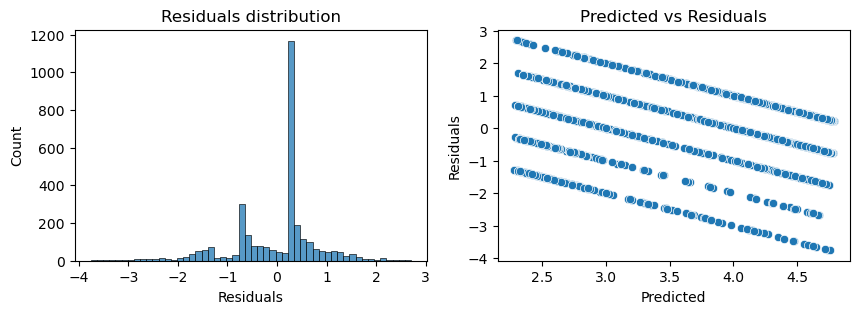

In [92]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.histplot(x=regression_model1_residuals, ax=axs[0])
sns.scatterplot(x=regression_model1_pred, y=regression_model1_residuals)

axs[0].set_title('Residuals distribution')
axs[0].set(xlabel='Residuals')

axs[1].set_title('Predicted vs Residuals')
axs[1].set(xlabel='Predicted', ylabel='Residuals')
plt.show()

### <center>❗❗Analyzing residuals of simple linear regression model❗❗

Clearly, there are some errors with this model, so let's just stop the analysis of the model here. First of all the residuals aren't normal, so our linear regression model assumption is false. Second of all, we predicted decimal values when the scale is discrete. 

Note that the predicted vs residuals plot is a common result of regression with discrete dependent variables, because there are only 5 choices you can predict, the residuals follow these 5 parallel bands.
</br></br>
More info on this pehnomenon here:</br>
https://stats.stackexchange.com/questions/287669/parallel-straight-lines-on-residuals-vs-predicted-values-plot

So now let's try a different regression model: ordinal regression. Because our dependent variable can be ordered and is categorical (ordinal), we can use ordinal regression. Ordinal regression is a type of logistic regression that works for more than 2 classes; it solves a classification problem for more than 2 classes. Here the classification problem is determing the star rating for a review. The result of the regression will be a vector of size 5 for each sample. The vector holds the probabilities of the rating being a 1, 2, 3, 4, or 5. To get the classification from these vectors, we simply take the index with the highest probability + 1 (since 0 indexed).

In [93]:
#create ordinal regression model with roberta scores as indep and rating as dep
regression_model2 = OrderedModel.from_formula(formula='rating ~ pos_roberta + neu_roberta + neg_roberta',\
                                             data=X_train.join(y_train)).fit()

In [94]:
regression_model2_pred = pd.DataFrame(regression_model2.predict(X_test)).apply(lambda x: x.argmax() + 1, axis=1)

In [95]:
regression_model2_residuals = y_test - regression_model2_pred

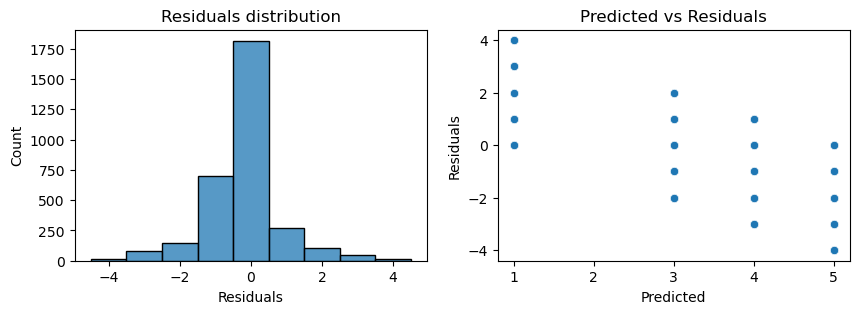

In [96]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.histplot(x=regression_model2_residuals, ax=axs[0], discrete=True)
sns.scatterplot(x=regression_model2_pred, y=regression_model2_residuals)

axs[0].set_title('Residuals distribution')
axs[0].set(xlabel='Residuals')

axs[1].set_title('Predicted vs Residuals')
axs[1].set(xlabel='Predicted', ylabel='Residuals')
plt.show()

### <center>❗❗Analyzing residuals of ordinal regression model❗❗

Okay, so we fixed the two issues we had before. Now we only predicted discrete values, and the residuals are somewhat normal.
However, there's another issue. If you look at the predicted vs residuals plot, you can see that our model never predicted 2 stars. This is because our training data has so few 2 stars, that being a 2 star review is never the highest probability. In other words, the imbalance in our data has affected our model negatively. 

Let's check the performance of this model by looking at accuracy and weighted f1 score, as well as distribution of predictions.

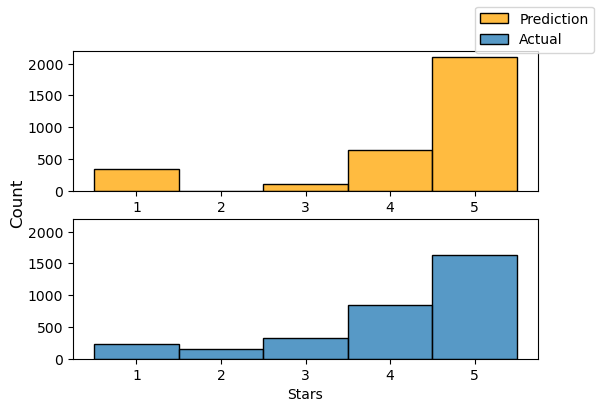

In [97]:
fig, axs = plt.subplots(2,1, figsize=(6,4), sharey=True)
sns.histplot(x=regression_model2_pred, discrete=True, ax=axs[0], label='Prediction', color='orange')
sns.histplot(x=y_test, discrete=True, ax=axs[1], label='Actual')

axs[0].set(xlabel=None, ylabel=None)
axs[1].set(xlabel='Stars', ylabel=None)
fig.supylabel("Count")
fig.legend()
plt.show()

In [98]:
print(f'Accuracy: {accuracy_score(y_test, regression_model2_pred)}')
print(f"f1_score: {f1_score(y_test, regression_model2_pred, average='weighted')}")

Accuracy: 0.5699937225360954
f1_score: 0.5184765059924523


### <center>❗❗Analyzing performance of ordinal regression model❗❗

So our model's predictions has a similar distribution to the actual values. Also, our model's accuracy is around 57% which is better than randomly guessing. It's f1 score is .51 which is okay but not good. 
This low f1 score is most likely because ordinal regression doesn't work very well with imbalanced data, and our data is heavily imabalanced. So instead of fine tuning this model, let's look for more classification models and see which produces the best accuracy and f1 score. But also, now let's use cross validation to ensure our model is more robust.

In [99]:
# shuffle data first since not using training data anymore:
X_s, y_s = shuffle(X, y)

In [100]:
forest_clf = RandomForestClassifier()
forest_clf_f1_score = cross_val_score(forest_clf,X_s,y_s,cv=5,scoring='f1_weighted')
forest_clf_f1_accuracy = cross_val_score(forest_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'Forest average accuracy + std: {forest_clf_f1_score.mean(), forest_clf_f1_score.std()}')
print(f"Forest average f1_score + std: {forest_clf_f1_accuracy.mean(), forest_clf_f1_accuracy.std()}")

Forest average accuracy + std: (0.6362489883007191, 0.012472587273966877)
Forest average f1_score + std: (0.642140078925702, 0.011416872979547816)


### <center>❗❗Analyzing performance of Random Forest❗❗

In [101]:
sgd_clf = SGDClassifier()
sgd_clf_f1_score = cross_val_score(sgd_clf,X_s,y_s,cv=5,scoring='f1_weighted')
sgd_clf_f1_accuracy = cross_val_score(sgd_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'SGD average accuracy + std: {sgd_clf_f1_score.mean(), sgd_clf_f1_score.std()}')
print(f"SGD average f1_score + std: {sgd_clf_f1_accuracy.mean(), sgd_clf_f1_accuracy.std()}")

SGD average accuracy + std: (0.4429484949858483, 0.019069104167375363)
SGD average f1_score + std: (0.5641630153277373, 0.009305598052540772)


### <center>❗❗Analyzing performance of Stochastic Gradient Descent❗❗

In [102]:
knn_clf = KNeighborsClassifier()
knn_clf_f1_score = cross_val_score(knn_clf,X_s,y_s,cv=5,scoring='f1_weighted')
knn_clf_f1_accuracy = cross_val_score(knn_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'KNN average accuracy + std: {knn_clf_f1_score.mean(), knn_clf_f1_score.std()}')
print(f"KNN average f1_score + std: {knn_clf_f1_accuracy.mean(), knn_clf_f1_accuracy.std()}")

KNN average accuracy + std: (0.5739867092032158, 0.013785076937675243)
KNN average f1_score + std: (0.5796084944496493, 0.015397911217188425)


### <center>❗❗Analyzing performance of K-Nearest Neighbors❗❗

In [103]:
svc_clf = SVC()
svc_clf_f1_score = cross_val_score(svc_clf,X_s,y_s,cv=5,scoring='f1_weighted')
svc_clf_f1_accuracy = cross_val_score(svc_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'Svc average accuracy + std: {svc_clf_f1_score.mean(), svc_clf_f1_score.std()}')
print(f"Svc average f1_score + std: {svc_clf_f1_accuracy.mean(), svc_clf_f1_accuracy.std()}")

Svc average accuracy + std: (0.5401244086919659, 0.010706283256139336)
Svc average f1_score + std: (0.5865144933708087, 0.010009329568392787)


### <center>❗❗Analyzing performance of Suppport Vector Classifier❗❗

In [104]:
categorical_NB_clf = CategoricalNB()
categorical_NB_clf_f1_score = cross_val_score(categorical_NB_clf,X_s,y_s,cv=5,scoring='f1_weighted')
categorical_NB_clf_accuracy = cross_val_score(categorical_NB_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'Categorical Naive Bayes average accuracy + std: {categorical_NB_clf_accuracy.mean(), categorical_NB_clf_accuracy.std()}')
print(f"Categorical Naive Bayes average f1_score + std: {categorical_NB_clf_f1_score.mean(), categorical_NB_clf_f1_score.std()}")

Categorical Naive Bayes average accuracy + std: (0.5179558337828503, 0.00013012330957993257)
Categorical Naive Bayes average f1_score + std: (0.35347306835477615, 0.0001473161873857265)


### <center>❗❗Analyzing performance of Categorical Naive Bayes❗❗

In [105]:
mult_NB_clf = MultinomialNB()
mult_NB_clf_f1_score = cross_val_score(mult_NB_clf,X_s,y_s,cv=5,scoring='f1_weighted')
mult_NB_clf_accuracy = cross_val_score(mult_NB_clf,X_s,y_s,cv=5,scoring='accuracy')
print(f'Multionmial Naive Bayes average accuracy + std: {mult_NB_clf_accuracy.mean(), mult_NB_clf_accuracy.std()}')
print(f"Multionmial Naive Bayes average f1_score + std: {mult_NB_clf_f1_score.mean(), mult_NB_clf_f1_score.std()}")

Multionmial Naive Bayes average accuracy + std: (0.5533652253735721, 0.006086941667609357)
Multionmial Naive Bayes average f1_score + std: (0.46292073992629845, 0.006797862289506721)


### <center>❗❗Analyzing performance of Multinomial Naive Bayes❗❗

So it turns out that Random Forest is the best classifier for our data. Though note that we could probably get better results by resampling our data to remove some of the class imbalances (undersample the 4 and 5 stars, oversample the 2 and 3 stars), though I will leave this as an exercise for the reader 😁.

More info on that here:
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=One%20approach%20to%20addressing%20the,the%20minority%20class%2C%20called%20oversampling.

Now let's see if we can improve our Forest classifier by adding more features such as price.

In [106]:
X2 = X.join(complete_df[['price']])
X2_s, y2_s = shuffle(X2, y)

In [107]:
forest_clf2 = RandomForestClassifier()
forest_clf2_f1_score = cross_val_score(forest_clf,X2_s,y2_s,cv=5,scoring='f1_weighted')
forest_clf2_f1_accuracy = cross_val_score(forest_clf,X2_s,y2_s,cv=5,scoring='accuracy')
print(f'2nd Forest average accuracy + std: {forest_clf2_f1_score.mean(), forest_clf2_f1_score.std()}')
print(f"2nd Forest average f1_score + std: {forest_clf2_f1_accuracy.mean(), forest_clf2_f1_accuracy.std()}")

2nd Forest average accuracy + std: (0.6412649880851655, 0.004148774482721585)
2nd Forest average f1_score + std: (0.656329197777967, 0.0037970935725663993)


### <center>❗❗Analyzing performance of 2nd attempt at Random Forest❗❗

In [108]:
X3 = X.join(complete_df[['price', 'size_inches', 'hhd_GB', 'ram_GB']])
X3_s, y3_s = shuffle(X3, y)

In [109]:
forest_clf3 = RandomForestClassifier()
forest_clf3_f1_score = cross_val_score(forest_clf,X3_s,y3_s,cv=5,scoring='f1_weighted')
forest_clf3_f1_accuracy = cross_val_score(forest_clf,X3_s,y3_s,cv=5,scoring='accuracy')
print(f'3rd Forest average accuracy + std: {forest_clf3_f1_score.mean(), forest_clf3_f1_score.std()}')
print(f"3rd Forest average f1_score + std: {forest_clf3_f1_accuracy.mean(), forest_clf3_f1_accuracy.std()}")

3rd Forest average accuracy + std: (0.6247668460235188, 0.010371430372930758)
3rd Forest average f1_score + std: (0.6443990195800093, 0.012699269009888277)


### <center>❗❗Analyzing performance of 3rd attempt at Random Forest❗❗

It seems like our original Forest Model that used only sentiment scores cannot be improved by adding more features.
So now, lets attempt to score some unlabeled text to see if we've accomplished our goal... 🤞

In [110]:
#fit the original forest model on all the data
forest_clf = forest_clf.fit(X,y)

In [111]:
#add some random sentences to test the predictions
str1 = "I HATE SCHOOOL. I SHOULDVE JOINED THE ARMY IM WASTING MY TIME OVER HERE"
str2 = "today is an awesome day. the sun is out and i'm loving it"
str3 = "the eiffel tower is very tall and made of metal. this is something not a lot of people know"
str4 = "this is quite sad, the day is almost over but at least im almost done with work"

In [112]:
#pass the unlabeled data to the forest model
print(f'{str1}: {forest_clf.predict([ROBERTA(str1)])[0]} stars', 
      f'{str2}: {forest_clf.predict([ROBERTA(str2)])[0]} stars', 
      f'{str3}: {forest_clf.predict([ROBERTA(str3)])[0]} stars', 
      f'{str4}: {forest_clf.predict([ROBERTA(str4)])[0]} stars', sep='\n')

I HATE SCHOOOL. I SHOULDVE JOINED THE ARMY IM WASTING MY TIME OVER HERE: 1 stars
today is an awesome day. the sun is out and i'm loving it: 5 stars
the eiffel tower is very tall and made of metal. this is something not a lot of people know: 5 stars
this is quite sad, the day is almost over but at least im almost done with work: 3 stars


### <center>❗❗Testing the random forest model on unlabeled data❗❗

So as you can see the predictions are alright. The prediction of str3 shows that our model is still biased towards positive scores since it gave a very neutral sentence 5 stars. Once again, we could probably fix this by resampling to remove class imbalances, but for now this will be fine.

YAAY! We accomplished goal 1. Now companies could potentially use our model to label unrated texts. This will allow them to quickly gauge how their customers feel through an easy to interpret star rating scale.

Now let's move on to goal 2, which I will remind you is to combine the sentiment scores and star rating into a single metric that is a more robust measure of sentiment.

## Goal 2: Combine the sentiment and star metrics into one robust metric

First before we do this, let's see why we would want to do this by seeing where Roberta predicted a sentiment score opposite of the star rating.

In [113]:
#find 1 star ratings with high positive roberta sentiment
pos_sentiment_1stars = complete_df[complete_df.rating == 1].\
sort_values(by="pos_roberta", ascending=False)[['rating','pos_roberta','review']]

In [114]:
for i,r in pos_sentiment_1stars.head(2).iterrows():
    rating, score, review = r.values
    print(f'Stars: {rating}', f'Positive sentiment: {score}', review, sep='\n')

Stars: 1
Positive sentiment: 0.9778086
The laptop looks so beautiful, my first impression was the color. I opened up the laptop and set it up. The setup process was so smooth. The laptop is very fast for online browsing and social media I was very pleased with it. The audio quality is good and the touch screen works perfect. The weight and size are just perfect for a student to put in the backpack.Update...The laptop slowed down and was terrible, not recommended
Stars: 1
Positive sentiment: 0.9744418
Good product given the price. Works great! . Will update if anything comes up


### <center>❗❗Analyzing disparities between stars and pos Roberta scores❗❗

As you can see the first review was initially positive but then they updated it 1 stars because the laptop broke down. The Roberta model assigned the review a very high positive sentiment because the review started off overwhelmingly positive, however, us being humans, we can recognize that this review is negative because the last sentence outweights the rest of the review since it is their most recent thoughts. Hence in this case star rating is better than sentiment score. 

However, the second review is purely positive and Roberta captured this appropriately despite the star being 1. So in this case the sentiment score is better. However, consider if in the second review, something bad happened to the customer's laptop, so they updated the stars but not the review. In this case the star rating would be a better indicator of overall sentiment. 

In [115]:
#find 5 star ratings with high negative Roberta sentiment
neg_sentiment_5stars = complete_df[complete_df.rating == 5].sort_values(by="neg_roberta", ascending=False)[['rating','neg_roberta','review']]

In [116]:
for i,r in neg_sentiment_5stars.head(2).iterrows():
    rating, score, review = r.values
    print(f'Stars: {rating}', f'Negative sentiment: {score}', review, sep='\n')

Stars: 5
Negative sentiment: 0.95504034
A waste of money because no boot code! I am not happy! I want my money back but it’s outside my warranty. Sad state of affairs. don’t buy this item Surf pro… garbage! it’s a waste of your hard earned money.
Stars: 5
Negative sentiment: 0.9493004
My HP laptop recently got a virus!  I REALLY MISS IT!!!! I purchased a Chromebook laptop and I HATE IT!!!!!  Everything is so different and I know the OLD WAYS so Chromebook WILL NOT DO!!!!!!!


### <center>❗❗Analyzing disparities between stars and neg Roberta scores❗❗

As you can see, these two star ratings are most likely misclicks since the reviews are purely negative. In this case, companies would appreciate the sentiment score more than the stars, since the sentiment score is more truthful to how their customers feel.

Hence, we can see that both stars and sentiment scores have their pros and cons as a measure of sentiment. Let's combine the two to make a single more robust score.

One approach, is to treat sentiment and star as equals and just take the average. However, to do this we need to ensure that they are both normalized to between \[0,1\] so that one does not affect the average more than the other. The sentiment scores are already in this range so we just have to update the ratings.

In [117]:
#normalize star ratings between 0 and 1
complete_df['norm_rating'] = (complete_df.rating - complete_df.rating.min()) / (complete_df.rating.max()  - complete_df.rating.min())

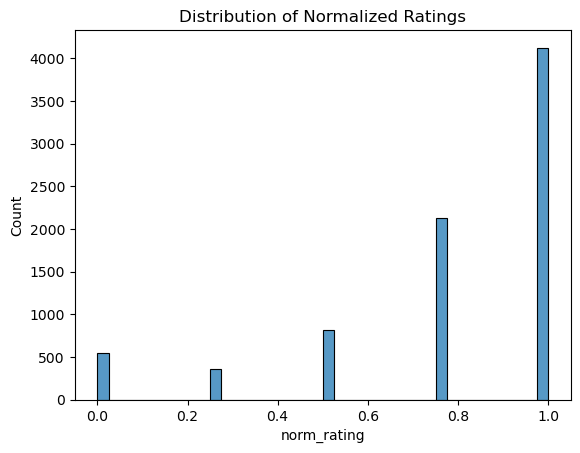

In [118]:
sns.histplot(data=complete_df, x='norm_rating')
plt.title('Distribution of Normalized Ratings')
plt.show()

Now we have another issue, we want to take the average of sentiment and rating, but we have multiple sentiments.

If we do something like (pos + neg + neu + norm_rating) / 2, the Roberta scores actually wouldnt affect the end result since pos + neg + neu is always 1. So we have to combine pos, neg, and neu scores into a single score that ranges from 0 to 1. One way to do this is a weighted average. For instance, let the positive score have a weight of 0.6, the neutral score a weight of 0.3, and the negative score a weight of 0.1, so the worst score would come from \[pos=0, neu=0, neg=1\] => 0.1 and the best score would come from \[pos=1, neu=0, neg=0\] => 0.6. However, these values don't range from \[0,1\] so we would have to normalize them once again like we did for the ratings.

So let's create this random variable through regression to learn the weights so that the combined sentiment scores look somewhat like the normalized ratings; afterall we know that rating and sentiment are closely related in distributions from previous visualizations. To do this we need to define the problem we want to optimize/minimize so lets define that problem as a function.

In [119]:
def problem(weights, scores, desired_outcome):
    #take the weighted average of the sentiment scores
    combined = (scores * weights).apply(sum, axis=1)
    #noremalize the weighted average between 0 and 1
    normalized = (combined - combined.min())/(combined.max()-combined.min())
    #minimize the sum of squared errors between the normalized sentiment score and the normalized star ratings
    SSE = ((desired_outcome - normalized) ** 2).sum()
    return SSE

In [120]:
#bound weights between -1 and 1
bounds = sp.optimize.Bounds([-1.,-1.,-1.],[1.,1.,1.])
#bound sum of weights between 0 and 1
lc = sp.optimize.LinearConstraint([[1,1,1]], lb=0, ub=1)

In [121]:
#have an initial guess of neg_w = 0.1, neu_w = 0.3, pos_w = 0.6
opt_weights = sp.optimize.differential_evolution(problem, x0=[0.1,0.3,0.6], bounds=bounds, constraints=lc,
                                   args=(complete_df[['neg_roberta', 'neu_roberta', 'pos_roberta']], \
                                                     complete_df.norm_rating)).x

In [122]:
#apply weights
combined_score = (complete_df[['neg_roberta', 'neu_roberta', 'pos_roberta']]  * opt_weights).apply(sum, axis=1)
normalized_sentiment_score = (combined_score - combined_score.min()) / (combined_score.max() - combined_score.min())

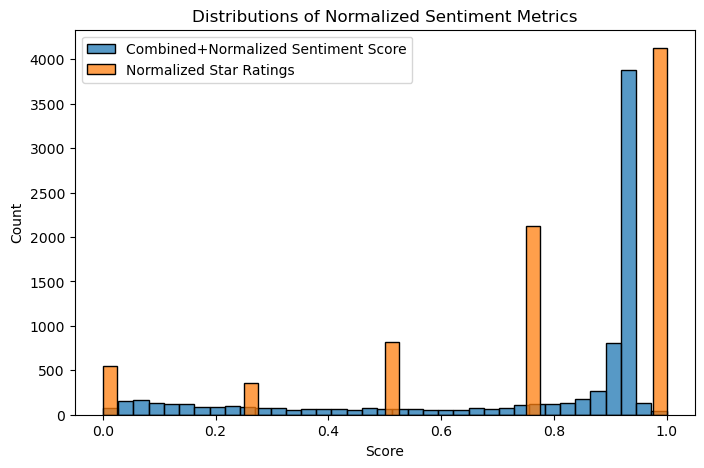

In [123]:
fig, axs = plt.subplots(1,1, figsize=(8,5))
sns.histplot(x=normalized_sentiment_score,ax=axs, label='Combined+Normalized Sentiment Score')
sns.histplot(data=complete_df, x='norm_rating', label='Normalized Star Ratings')
plt.title('Distributions of Normalized Sentiment Metrics')
axs.set(xlabel='Score', ylabel='Count')
plt.legend()
plt.show()

### <center>❗❗Result of attempting to fit combined+normalized sentiment score to the normalized star ratings❗❗

I think this is good enough for now. The issue of trying to fit the combined+normalized sentiment scores to the normalized rating is that the normalized rating is still categorically distributed, whereas Roberta scores are inherently continuous.

So now lets take the average of these 2 scores and create our final sentiment metric.

In [124]:
#take the unweighted average
complete_df['sentiment_measure'] = (complete_df.norm_rating + normalized_sentiment_score)/2

Now let's check if our sentiment measure actually works by checking where our new sentiment measure disagrees with star rating or roberta score.

In [125]:
#redo our previous analysis but with sentiment measure now
new_1star_pos = complete_df[complete_df.rating == 1].\
                sort_values(by="pos_roberta", ascending=False)[['rating','pos_roberta','sentiment_measure','review']]

In [126]:
for i,r in new_1star_pos.head(2).iterrows():
    rating, score, sentiment_measure, review = r.values
    print(f'Stars: {rating}', f'Roberta Positive sentiment: {score}', f'New Sentiment Measure: {sentiment_measure}', review, sep='\n')

Stars: 1
Roberta Positive sentiment: 0.9778086
New Sentiment Measure: 0.46207437202371904
The laptop looks so beautiful, my first impression was the color. I opened up the laptop and set it up. The setup process was so smooth. The laptop is very fast for online browsing and social media I was very pleased with it. The audio quality is good and the touch screen works perfect. The weight and size are just perfect for a student to put in the backpack.Update...The laptop slowed down and was terrible, not recommended
Stars: 1
Roberta Positive sentiment: 0.9744418
New Sentiment Measure: 0.46273585333631484
Good product given the price. Works great! . Will update if anything comes up


### <center>❗❗Sentiment measure found a happy medium between 1 star and high positive Roberta score❗❗

In [127]:
#redo our previous analysis but with sentiment measure now
new_5star_neg = complete_df[complete_df.rating == 5].\
                sort_values(by="neg_roberta", ascending=False)[['rating','neg_roberta','sentiment_measure','review']]

In [128]:
for i,r in new_1star_pos.head(2).iterrows():
    rating, score, sentiment_measure, review = r.values
    print(f'Stars: {rating}', f'Roberta Negative sentiment: {score}', f'New Sentiment Measure: {sentiment_measure}', review, sep='\n')

Stars: 1
Roberta Negative sentiment: 0.9778086
New Sentiment Measure: 0.46207437202371904
The laptop looks so beautiful, my first impression was the color. I opened up the laptop and set it up. The setup process was so smooth. The laptop is very fast for online browsing and social media I was very pleased with it. The audio quality is good and the touch screen works perfect. The weight and size are just perfect for a student to put in the backpack.Update...The laptop slowed down and was terrible, not recommended
Stars: 1
Roberta Negative sentiment: 0.9744418
New Sentiment Measure: 0.46273585333631484
Good product given the price. Works great! . Will update if anything comes up


### <center>❗❗Sentiment measure found a happy medium between 5 star and high negative Roberta score❗❗

So our measure seems to be working as intended 😄.


Finally we are done with our two goals. So let's make some policy decision using what we have now.

# Step 6: Policy and Insight 💵💵

So now we aim to gain insight and enact policy decisions based off what we learned so far. Let's see what laptops are loved the most, we can find this out using our new sentiment measure.

In [129]:
#aggregate back to original format so that each sample is a laptop, 
#and take the average sentiment_measure of the laptop's reviews
samples = []
for name, x in complete_df.groupby('name'):
    sample = x[['name', 'size_inches', 'brand', 'hhd_GB', 'ram_GB',\
            'os', 'cpu', 'graphics_card', 'price', 'sentiment_measure']].iloc[0]
    sample['sentiment_measure'] = x.sentiment_measure.mean()
    samples.append(sample)

final_df = pd.DataFrame(samples).reset_index(drop=True)

In [130]:
#groupby features and sort by highest sentiment
print('Top 5 most loved laptops according to the new Sentiment Measure')
for i, name in enumerate(final_df.sort_values(by='sentiment_measure', ascending=False).head().name, start=1):
    print(f'\t{i}. {name}')

print('Top 5 most loved brands according to the new Sentiment Measure')
for i, name in enumerate(final_df.groupby(by='brand').sentiment_measure.mean().\
                         sort_values(ascending=False).head().index, start=1):
    print(f'\t{i}. {name}')
    
print('Top 5 most loved os according to the new Sentiment Measure')
for i, name in enumerate(final_df.groupby(by='os').sentiment_measure.mean().\
                         sort_values(ascending=False).head().index, start=1):
    print(f'\t{i}. {name}')
    
print('Top 5 most loved cpu according to the new Sentiment Measure')
for i, name in enumerate(final_df.groupby(by='cpu').sentiment_measure.mean().\
                         sort_values(ascending=False).head().index, start=1):
    print(f'\t{i}. {name}')

print('Top 5 most loved gpu according to the new Sentiment Measure')
for i, name in enumerate(final_df.groupby(by='graphics_card').sentiment_measure.mean().\
                         sort_values(ascending=False).head().index, start=1):
    print(f'\t{i}. {name}')

Top 5 most loved laptops according to the new Sentiment Measure
	1. Lenovo IdeaPad 3 Laptop Computer
	2. Razer Blade 15 Base Gaming Laptop 2020
	3. MSI 15.6" FHD 144Hz Gaming Laptop
	4. NewLenovo Student Business PC Notebook 14" HD Laptop Computer
	5. MSI GS65 Stealth-432 15.6" Gaming Laptop
Top 5 most loved brands according to the new Sentiment Measure
	1. MSI
	2. LG
	3. Acer
	4. ASUS
	5. Microsoft
Top 5 most loved os according to the new Sentiment Measure
	1. mac
	2. chrome
	3. other
	4. windows 10
	5. windows 11
Top 5 most loved cpu according to the new Sentiment Measure
	1. ryzen 3
	2. celeron
	3. ryzen 7
	4. amd
	5. other
Top 5 most loved gpu according to the new Sentiment Measure
	1. gtx
	2. dedicated
	3. intel
	4. integrated
	5. rtx


### <center>❗❗Laptops and features that make people happiest according to our new sentiment measure❗❗

Now let's see if there's any new correlations between our sentiment measures and the numeric data.

In [131]:
final_df.corr(numeric_only=True)

,size_inches,hhd_GB,ram_GB,price,sentiment_measure
size_inches,1.000000,0.462015,0.415949,0.418540,-0.021118
hhd_GB,0.462015,1.000000,0.723587,0.689339,-0.076979
ram_GB,0.415949,0.723587,1.000000,0.686657,-0.091338
price,0.418540,0.689339,0.686657,1.000000,-0.076666
sentiment_measure,-0.021118,-0.076979,-0.091338,-0.076666,1.000000


Seems like nothing really changed much, which is a good thing since we don't want our new sentiment measure to completely alter the original relationships between variables.

So, now you know what features to look for when buying a laptop, and sellers may know what features to use in their laptops to make happier customers.

Also, don't forget that we have a model that can predict stars from text, so companies can use that model for whatever unlabeled text they have to help guide them in their policy decisions. I mention this because I don't have any unlabeled text readily available but it was an important goal we accomplished in this project that can be used in real life situations.

## Improvements

Although we accomplished alot in this tutorial, there are a lot of improvements that can still be made. For instance, we could attempt imputation instead of removing all missing data. We could also have resampled our data to remove class imbalances in the star ratings, thus leading to better ML models. Also, we could've trained our own longformer so that we don't have to truncate tokens.

Anyways, thats it for now, thanks for taking the time to read this tutorial!! 💗💗💗

# Sources

- https://www.youtube.com/watch?v=QpzMWQvxXWk&t=1442s
- https://medium.com/analytics-vidhya/sentiment-analysis-with-vader-label-the-unlabeled-data-8dd785225166
- https://github.com/cjhutto/vaderSentiment#about-the-scoring
- https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
- https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
- https://crunchingthedata.com/when-to-use-ordinal-logistic-regression/#:~:text=Ordinal%20logistic%20regression%20is%20generally,ordering%20to%20your%20outcome%20variable.
- https://www.statista.com/statistics-glossary/definition/382/standard_deviation/#:~:text=The%20standard%20deviation%20measures%20the,in%20a%20set%20of%20data.